In [1]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta
from time import time

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.utils import shuffle


Very_Start = time()

### DEFINITION DE TOUS LES PARAMETRES

In [78]:
# @param Does it save the figure ?
save_fig    = True
save_folder = 'UC2_fig'

# @param Connexion à la DB
driver   = '{ODBC Driver 17 for SQL Server}'
server   = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login    = ('DRIVER=' + driver + 
         ';SERVER='   + server + 
         ';Trusted_Connection=yes;')


# @param Definition des table et colonnes --> Dépendent de la DB
DB             = "Archive2018_2019_prod"
TABLE_CONSO    = "Consommateur"
TABLE_ENTETE   = "Recette_entete_ticket"
TEMPS_ENTETE   = TABLE_ENTETE             + ".TEMPS.KEY_Date_reel_de_la_transaction"
NUMERO_ENTETE  = TABLE_ENTETE             + ".Numero_ticket"
TABLE_DETAIL   = "Recette_detail_ticket"
TEMPS_DETAIL   = TABLE_DETAIL             + ".TEMPS.KEY_Date_reel_transaction"
NUMERO_DETAIL  = TABLE_DETAIL             + ".Numero_ticket"
TABLE_ARTICLE  = "Article_meti_HIST"
TABLE_UNIVERS  = "Univers"

Univers_Depth  = 3            # Jusqu'où on ira dans l'univers ? = [1;4]

# @param Variable influançant la sélection des données
nbr_client     = -1           # Nombre de clients à sélectionner. MAX = 148188. -1 --> ALL
client_tresh   = 20           # Nombre d'article que le client doit avoir acheter pour être mis dans un segment
univers_tresh  = 20           # Nombre d'article acheté de l'univers pour qu'il soit pris en compte

# @param Sur la normalization des données
Standard_Norm  = True        # Défini si on utilise la Normalization Standard
Standard_Tresh = 1            # Seuil d'acceptabilité des cluster en normalization standard
MinMax_Norm    = False        # Défini si on utilise la Normalization Minmax
MinMax_Tesh    = .3           # Seuil d'acceptabilité des cluster par défaut

# @param Sur le modèle KMean
K              = 14           # Nombre de segment. K = 21 -> 10% client d'exclu ; K = 15 -> 15% client exclu ; K = 9 -> 20% exclu 
n_init         = 50           # Nombre de run du KMean pour trouver le meilleur min

# @param Sur l'analyse des données
do_Analysis    = False         # Est-ce qu'on fait l'analyse des Elbow ou pas ?
Kmin           = 5            # Nombre de cluster au début de l'analyse
Kmax           = 30           # Nombre de cluster à la fin de l'analyse

nbr_dim_keep   = 20
K_PCA          = K

max_fitted = 10000
method = 'ward' # ward complete average single

threeD = False 

In [3]:
# TEST Connexion
params = urllib.parse.quote_plus(login)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = engine.connect()

df = pd.read_sql("SELECT TOP(10) ["+TABLE_CONSO+".KEY] FROM ["+DB+"].[DWH].[Dim_"+TABLE_CONSO+"]", conn)
print(df)

conn.close()

   Consommateur.KEY
0                -1
1                 1
2                 2
3                 3
4                 4
5                 5
6                 6
7                 7
8                 8
9                 9


## LOAD & PREPROCESSING DATA

In [4]:
start = time()

sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] AS ''' + TABLE_UNIVERS + '''
,[''' + TABLE_ENTETE + '''.''' + TABLE_CONSO + '''.KEY] AS ''' + TABLE_CONSO + '''
FROM  ['''      + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL + ''']
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE + '''] 
ON    [''' + TEMPS_DETAIL  +'''] = [''' + TEMPS_ENTETE  + '''] 
AND   [''' + NUMERO_DETAIL +'''] = [''' + NUMERO_ENTETE + ''']
INNER JOIN [''' + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE + ''']
ON ['''    + TABLE_DETAIL  + '''.'''    + TABLE_ARTICLE + '''.KEY] = [''' + TABLE_ARTICLE + '''.KEY] 
WHERE [''' + TABLE_ENTETE  + '''.'''    + TABLE_CONSO   + '''.KEY] > 0 
AND   [''' + TABLE_ARTICLE + '''.'''    + TABLE_UNIVERS + '''.KEY] != 388'''
if nbr_client != -1:
    sql_command +=  ''' AND [''' + TABLE_ENTETE  +'''.'''     + TABLE_CONSO   + '''.KEY] < '''  + str(nbr_client)

print(sql_command)

conn = engine.connect()
df_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 3min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_univers)
print(nbr_data)

SELECT [Article_meti_HIST.Univers.KEY] AS Univers
,[Recette_entete_ticket.Consommateur.KEY] AS Consommateur
FROM  [Archive2018_2019_prod].[DWH].[Fact_Recette_detail_ticket]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_entete_ticket] 
ON    [Recette_detail_ticket.TEMPS.KEY_Date_reel_transaction] = [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] 
AND   [Recette_detail_ticket.Numero_ticket] = [Recette_entete_ticket.Numero_ticket]
INNER JOIN [Archive2018_2019_prod].[DWH].[Dim_Article_meti_HIST]
ON [Recette_detail_ticket.Article_meti_HIST.KEY] = [Article_meti_HIST.KEY] 
WHERE [Recette_entete_ticket.Consommateur.KEY] > 0 
AND   [Article_meti_HIST.Univers.KEY] != 388
Time Taken to load DB: ~189secondes
10715545


In [5]:
start = time()

sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY],
    [''' + TABLE_UNIVERS  + '''.Libelle_univers1_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR]
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']'''
print(sql_command)

conn = engine.connect()
df_my_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 0s
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
print(df_my_univers)

SELECT [Univers.KEY],
    [Univers.Libelle_univers1_FR], 
    [Univers.Libelle_univers2_FR], 
    [Univers.Libelle_univers3_FR], 
    [Univers.Libelle_univers4_FR]
    FROM [Archive2018_2019_prod].[DWH].[Dim_Univers]
Time Taken to load DB: ~0secondes
     Univers.KEY Univers.Libelle_univers1_FR Univers.Libelle_univers2_FR  \
0             -1                           ?                           ?   
1              1               PRET A MANGER      SERVICE TRAITEUR FROID   
2              2               PRET A MANGER                MEUBLE CHAUD   
3              3               PRET A MANGER                MEUBLE CHAUD   
4              4               PRET A MANGER                MEUBLE CHAUD   
..           ...                         ...                         ...   
485          485               PRET A MANGER                     SALADES   
486          486               PRET A MANGER                     SALADES   
487          487  APERITIF   ENTREES   TAPAS                     

In [6]:
univers_correspondance = {}
deleted = set()
for item in df_my_univers.values:
    if item[0] in deleted:
        continue
    for cor in df_my_univers.values: 
        if item[0] != cor[0]:
            if (
                item[1] == cor[1] and
                (item[2] == cor[2] or Univers_Depth < 2) and
                (item[3] == cor[3] or Univers_Depth < 3) and
                (item[4] == cor[4] or Univers_Depth < 4)
            ):
                univers_correspondance[cor[0]] = item[0]
                deleted.add(cor[0])
print(univers_correspondance)

{428: 1, 429: 1, 3: 2, 4: 2, 5: 2, 8: 7, 28: 27, 32: 31, 39: 38, 40: 38, 42: 41, 43: 41, 44: 41, 46: 45, 47: 45, 48: 45, 49: 45, 50: 45, 462: 51, 475: 51, 62: 61, 63: 61, 71: 70, 72: 70, 73: 70, 89: 88, 90: 88, 91: 88, 93: 92, 456: 125, 463: 125, 464: 125, 465: 125, 466: 125, 467: 125, 468: 125, 130: 129, 137: 136, 139: 138, 140: 138, 181: 180, 182: 180, 183: 180, 184: 180, 185: 180, 186: 180, 187: 180, 469: 213, 476: 213, 216: 215, 218: 217, 225: 224, 227: 226, 457: 228, 458: 228, 459: 228, 470: 228, 477: 228, 471: 229, 472: 229, 245: 244, 246: 244, 247: 244, 248: 244, 249: 244, 250: 244, 251: 244, 252: 244, 253: 244, 254: 244, 255: 244, 256: 244, 281: 280, 282: 280, 283: 280, 454: 322, 473: 322, 461: 325, 474: 325, 487: 327, 488: 327, 345: 344, 347: 346, 349: 348, 350: 348, 351: 348, 352: 348, 353: 348, 354: 348, 356: 355, 357: 355, 358: 355, 359: 355, 360: 355, 361: 355, 363: 362, 364: 362, 390: 362, 391: 362, 393: 392, 394: 392, 395: 392, 396: 392, 397: 392, 398: 392, 399: 392, 400

In [76]:
start = time()
dict_client_univ = {}

for i in range(nbr_data):
    univ   = df_univers[TABLE_UNIVERS][i]
    client = df_univers[TABLE_CONSO][i]
    if univ == -1:
        continue
    
    if univ in deleted:
        univ = univers_correspondance[univ]
    
    if not client in dict_client_univ:
        dict_client_univ[client] = {}
        
    if not univ in dict_client_univ[client]:
        dict_client_univ[client][univ] = 0
    dict_client_univ[client][univ] += 1

to_remove = []
for k,v in dict_client_univ.items():
    if sum(v.values()) < client_tresh:
        to_remove.append(k)
#     else:
#         maxi = max(v.values())
#         dict_client_univ[k] = {key:value/maxi for key,value in v.items()}

for k in to_remove:
    del dict_client_univ[k]
        
    
clients_data = pd.DataFrame(index = dict_client_univ.keys(),
                        data = dict_client_univ.values())
clients_data = clients_data.replace(float('NaN'), 0)
 
print(clients_data)

# environ 10s * nbr_client/10.000
print("Time Taken to load Dataframe: ~" + str(int(time() - start)) + "secondes")

        344  200   171  149   213  122  119  372   189   403  ...  179  424  \
94071   2.0  3.0  65.0  4.0  75.0  7.0  2.0  1.0  15.0  10.0  ...  0.0  0.0   
101303  2.0  0.0  16.0  2.0   0.0  0.0  0.0  0.0   0.0   0.0  ...  0.0  0.0   
57046   1.0  0.0   4.0  0.0   0.0  0.0  1.0  0.0   4.0  10.0  ...  0.0  0.0   
100539  3.0  0.0  39.0  3.0   0.0  0.0  0.0  0.0   0.0  39.0  ...  0.0  0.0   
10995   1.0  1.0   1.0  0.0   2.0  4.0  0.0  0.0   5.0   0.0  ...  0.0  0.0   
...     ...  ...   ...  ...   ...  ...  ...  ...   ...   ...  ...  ...  ...   
139223  0.0  0.0   1.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0  ...  0.0  0.0   
139285  0.0  0.0   3.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0  ...  0.0  0.0   
147120  0.0  0.0   2.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0  ...  0.0  0.0   
148003  0.0  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0  ...  0.0  0.0   
148172  0.0  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0  ...  0.0  0.0   

        237  490  7    261  202  205  479  36   
94

In [85]:
# Standard Normalization
def standard_normalization(df):
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(df)
    return pd.DataFrame(index = df.index, columns = df.columns,data = scaled_values)

# Min-Max Normalization
def minmax_normalization(df):
    scaler = MinMaxScaler() 
    scaled_values = scaler.fit_transform(df) 
    return pd.DataFrame(index = df.index, columns = df.columns,data = scaled_values)

norm_clients_data = clients_data.copy()
if Standard_Norm:
    norm_clients_data = standard_normalization(norm_clients_data)
if MinMax_Norm:
    norm_clients_data = minmax_normalization(norm_clients_data)

if MinMax_Norm or not Standard_Norm: 
    for column in norm_clients_data:
        if sum(norm_clients_data[column]) < univers_tresh:
            norm_clients_data = norm_clients_data.drop(columns = column)

# shuffle rows        
norm_clients_data = shuffle(norm_clients_data) 
# shuffle columns
norm_clients_data = norm_clients_data[shuffle(norm_clients_data.columns)]
print(norm_clients_data)

             29        308       304       118       289       53        271  \
102537 -0.186499 -0.055373 -0.030879 -0.079592 -0.086578 -0.129617 -0.151418   
74212  -0.186499 -0.055373 -0.030879 -0.079592 -0.086578 -0.129617 -0.151418   
31061  -0.186499 -0.055373 -0.030879 -0.079592 -0.086578 -0.129617 -0.151418   
103162 -0.186499 -0.055373 -0.030879 -0.079592 -0.086578 -0.129617 -0.151418   
25600  -0.186499 -0.055373 -0.030879 -0.079592 -0.086578 -0.129617 -0.151418   
...          ...       ...       ...       ...       ...       ...       ...   
53612   0.323809 -0.055373 -0.030879 -0.079592 -0.086578 -0.129617 -0.151418   
116522 -0.186499 -0.055373 -0.030879 -0.079592 -0.086578 -0.129617 -0.151418   
133394 -0.186499 -0.055373 -0.030879 -0.079592 -0.086578 -0.129617 -0.151418   
66932  -0.186499 -0.055373 -0.030879 -0.079592 -0.086578 -0.129617 -0.151418   
120984 -0.186499 -0.055373 -0.030879 -0.079592 -0.086578 -0.129617 -0.151418   

            319       228       232  ..

# SEGMENTATION DE LA CLIENTELE PAR KMEANS

In [9]:
if do_Analysis:
    start = time()
    
    distorsions = []
    for k in range(Kmin, Kmax):
        print(k, end = ' ')
        model = KMeans(n_clusters=k)
        model.fit(norm_clients_data)
        distorsions.append(model.inertia_)

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(Kmin, Kmax), distorsions)
    plt.grid(True)
    plt.title('Elbow curve')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Elbow_Curve.jpg")
    
    plt.show()
    # environ 10s*Kmax
    print("Time Taken to generate Elbow Curve : ~" + str(int(time() - start)) + "secondes")

In [10]:
if do_Analysis:
    start = time()

    distorsions = []
    for k in range(Kmin, Kmax):
        print(k, end = ' ')
        model = KMeans(n_clusters=k)
        model.fit(norm_clients_data)
        cluster = model.predict(norm_clients_data)
        cluster_centers = model.cluster_centers_

        treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh
        NACK = 0
        for i in range(len(cluster_centers)):
            if sum([(1 if c > treshold else 0) for c in cluster_centers[i]]) == 0:
                NACK += cluster.tolist().count(i)

        distorsions.append(NACK/len(cluster))

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(Kmin, Kmax), distorsions)
    plt.grid(True)
    plt.title('Exclude Elbow curve')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Exclude_Elbow_Curve.jpg")
    
    plt.show()
    

    # environ 10s*Kmax
    print("Time Taken to generate Exclude Elbow Curve : ~" + str(int(time() - start)) + "secondes")

In [42]:
K=14

start = time()
model = KMeans(K, n_init = n_init)
model.fit(norm_clients_data)
cluster = model.labels_
# environ 1s * n_init / K/10
print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

Time Taken to fit model : ~51secondes


In [43]:
cluster_centers = model.cluster_centers_

interest = {i:[] for i in range(K)}

treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh

for i in range(len(cluster_centers)):
    for j in range(len(cluster_centers[i])):
        if cluster_centers[i][j] > treshold:
            interest[i].append(norm_clients_data.columns[j])

In [44]:
NACK = 0

conn = engine.connect()
for key,values in interest.items():
    print("\n\nCluster", key, end=': ')
    proportion = cluster.tolist().count(key)*100/len(cluster)
    print(round(proportion,2),"%",)
    
    if len(values) == 0:
        NACK += proportion
        continue
    
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
    ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
    WHERE '''
    for v in values:
        sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
    sql_command = sql_command[:-3]
    #print(sql_command)

    df_libele = pd.read_sql(sql_command, conn)
    print(df_libele.to_string(index=False))
conn.close()

print("\nNACK =", round(NACK,2),"%")



Cluster 0: 5.86 %
 Univ_KEY         Univ_1                       Univ_2        Univ_3
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS    MINI PAINS
      299 PETIT DEJEUNER                 VIENNOISERIE VIENNOISERIES


Cluster 1: 13.18 %
 Univ_KEY        Univ_1     Univ_2            Univ_3
      392 PRET A MANGER SANDWICHES SANDWICHES FROIDS


Cluster 2: 3.64 %
 Univ_KEY        Univ_1         Univ_2        Univ_3
      402 PRET A MANGER PLATS PREPARES  CHINESE FOOD
      408 PRET A MANGER PLATS PREPARES JAPANESE FOOD
      412 PRET A MANGER PLATS PREPARES     THAI FOOD


Cluster 3: 8.61 %
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD
      405 PRET A MANGER PLATS PREPARES   ITALIAN FOOD


Cluster 4: 4.34 %
 Univ_KEY         Univ_1                       Univ_2        Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS     BAGUETTES
      299 PETIT DEJEUNER                 VIENNOISERIE VIENNOISERIES


Cluster 5

In [14]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~389secondes


# VISUALISATION PCA

In [74]:
def PCA_Visualisation(data, target=None, centroid=None, method = "", threeD = False):
    start = time()

    model_pca = PCA(n_components= 2)
    predict = model_pca.fit(data).transform(data)
    
    
    print('Explained variance ratio from PCA: {}'.format(model_pca.explained_variance_ratio_))
    
    plt.figure(figsize=(15, 7))  
    if target:
        plt.scatter(predict[:,0],predict[:,1], c=target, alpha=.8)
    else: 
        plt.scatter(predict[:,0],predict[:,1])
    if centroid:
        clust_predict = model_pca.transform(centroid)
        plt.scatter(clust_predict[:,0],clust_predict[:,1], color='r')
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA of dataset - ' + method + ' - Cluster = ' + str(K))

    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_PCA_Cluster-"+str(K)+"-"+method+".jpg")
    
    if threeD:
        model_pca = PCA(n_components= 3)
        predict = model_pca.fit(data).transform(data)
        print('Explained variance ratio from PCA: {}'.format(model_pca.explained_variance_ratio_))


        plt.figure(figsize=(30, 30)) 
        ax = plt.axes(projection='3d')

        ax.scatter3D(predict[:,0], predict[:,1], predict[:,2], c=target);

        plt.title('PCA of dataset in 3D - ' + method)

        if save_fig:
            plt.savefig(save_folder+"/"+str(Univers_Depth)+"_PCA_Cluster_3D-"+str(K)+"-"+method+".jpg")
    
    # environ 1.5s
    print("Time Taken to show PCA : ~" + str(int(time() - start)) + "secondes")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.07575835 0.06477211]
Time Taken to show PCA : ~0secondes


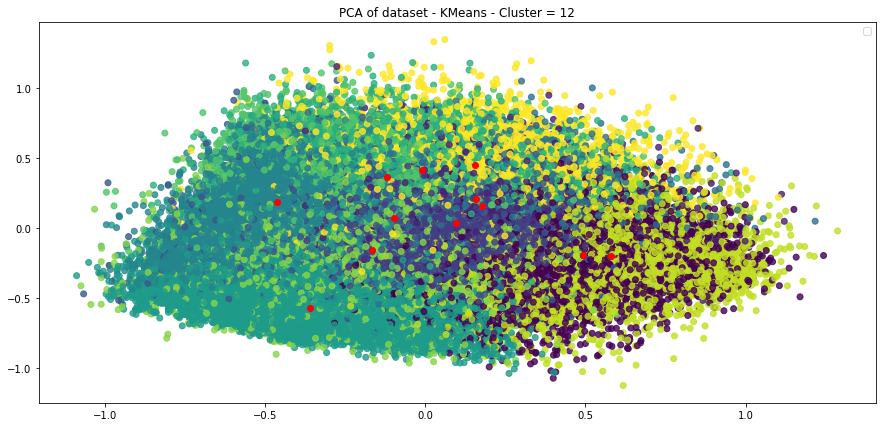

In [16]:
PCA_Visualisation(norm_clients_data,
                  cluster, 
                  cluster_centers,
                  method = 'KMeans',
                  threeD = threeD)

# SEGMENTATION HIERARCHICAL CLUSTERING

In [17]:
if do_Analysis:
    start = time()
    
    plt.figure(figsize=(15, 7))  
    plt.title("Dendrograms")  
    dend = shc.dendrogram(shc.linkage(norm_clients_data.head(max_fitted), method=method), p = 50, truncate_mode = 'level')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Dendogram_"+method+".jpg")
    plt.show()


    # Enivron 250s*(client/10000)²
    print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

In [18]:
from sklearn.cluster import AgglomerativeClustering

start = time()

hierarchical_model = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage=method)  
hierarchical_model.fit(norm_clients_data.head(max_fitted))
print(hierarchical_model)
# 15s * (N/10k)²
print("Time Taken to fit/predict model : ~" + str(int(time() - start)) + "secondes")

AgglomerativeClustering(n_clusters=12)
Time Taken to fit/predict model : ~19secondes


In [19]:

start = time()

hierarchical_centroid   = [{c:0 for c in norm_clients_data.columns} for _ in range(K)]
hierarchical_cluster    = hierarchical_model.labels_
hierarchical_proportion = [0 for _ in range(K)]
for i in range(max_fitted):
    for c in norm_clients_data.columns:
        hierarchical_centroid[hierarchical_cluster[i]][c] += norm_clients_data[c][norm_clients_data.index[i]]
    hierarchical_proportion[hierarchical_cluster[i]]  += 1

for i in range(K):
    for c in norm_clients_data.columns:
        hierarchical_centroid[i][c] /= hierarchical_proportion[i]

hierarchical_interest = {i:[] for i in range(K)}

treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh

for i in range(len(hierarchical_centroid)):
    for c in norm_clients_data.columns:
        if hierarchical_centroid[i][c] > treshold:
            hierarchical_interest[i].append(c)

# environ 30s
print("Time Taken to get interests : ~" + str(int(time() - start)) + "secondes")

Time Taken to get interests : ~30secondes


In [20]:
NACK = 0

conn = engine.connect()
for key,values in hierarchical_interest.items():
    print("\n\nCluster", key, end=': ')
    proportion = hierarchical_proportion[key]*100/max_fitted
    print(round(proportion,2),"%",)
    
    if len(values) == 0:
        NACK += proportion
        continue
    
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
    ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
    WHERE '''
    for v in values:
        sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
    sql_command = sql_command[:-3]
    #print(sql_command)

    df_libele = pd.read_sql(sql_command, conn)
    print(df_libele.to_string(index=False))
conn.close()

print("\nNACK =", round(NACK,2),"%")



Cluster 0: 22.86 %


Cluster 1: 4.92 %
 Univ_KEY         Univ_1                       Univ_2    Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS     PAINS


Cluster 2: 9.28 %
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD
      405 PRET A MANGER PLATS PREPARES   ITALIAN FOOD


Cluster 3: 10.5 %
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Cluster 4: 9.42 %
 Univ_KEY           Univ_1                       Univ_2         Univ_3
      180 FRUITS   LEGUMES                      LEGUMES AUTRES LEGUMES
      297   PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS          PAINS


Cluster 5: 13.24 %
 Univ_KEY         Univ_1       Univ_2            Univ_3
      299 PETIT DEJEUNER VIENNOISERIE     VIENNOISERIES
      392  PRET A MANGER   SANDWICHES SANDWICHES FROIDS


Cluster 6: 4.29 %
 Univ_KEY   Univ_1 

Explained variance ratio from PCA: [0.07688698 0.06429064]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Time Taken to show PCA : ~0secondes


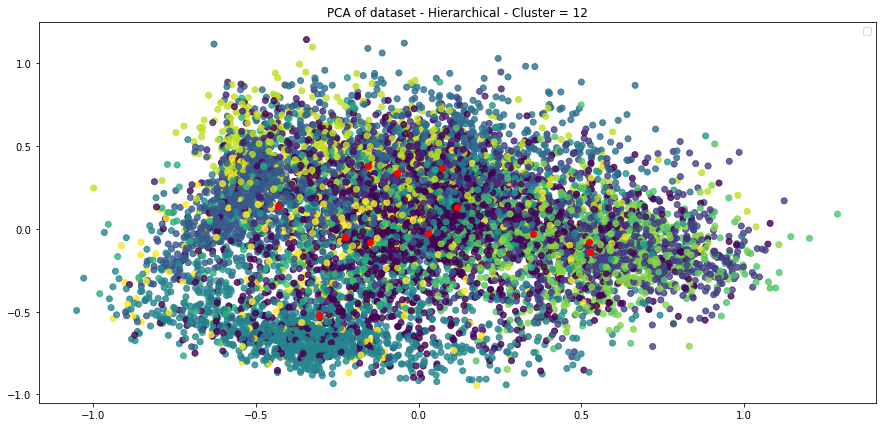

In [21]:
PCA_Visualisation(norm_clients_data.head(max_fitted), 
                  hierarchical_cluster,
                  [list(dic.values()) for dic in hierarchical_centroid],
                  method = 'Hierarchical',
                  threeD = threeD)

In [22]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~442secondes


## PCA Dimension reductor + KMeans

In [23]:
if do_Analysis:
    min_analyzed_dim = 0
    max_analyzed_dim = len(norm_clients_data.columns)
    
    model_pca = PCA(n_components= max_analyzed_dim)
    predict = model_pca.fit(norm_clients_data).transform(norm_clients_data)
    
    total_coef = {i:1-sum(model_pca.explained_variance_ratio_[:i]) 
                  for i in range(min_analyzed_dim,max_analyzed_dim)}
    print(total_coef)
    plt.figure(figsize=(15, 7)) 
    plt.plot(total_coef.keys(), total_coef.values())
    plt.grid(True)
    plt.title('PCA Reduction : Quantitée Relative Perdue en fonction du nombre de dimension')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_PCA_Reduction_Proportion.jpg")
    
    plt.show()
    

In [24]:
model_pca = PCA(n_components= nbr_dim_keep)
predict = model_pca.fit(norm_clients_data).transform(norm_clients_data)

In [25]:
new_datas = pd.DataFrame(index=norm_clients_data.index, data = predict)
print(new_datas)

              0         1         2         3         4         5         6   \
106509  0.008871 -0.488121 -0.216761  0.026150  0.243502 -0.049158  0.014888   
142337 -0.223136 -0.748142 -0.289048 -0.324729  0.300189  0.177950  0.070767   
23698  -0.350870  0.099126 -0.142540  0.732361 -0.624147 -0.210687  0.244761   
62324   0.420372  0.286855  0.259878  0.645783  0.213559  0.005662 -0.050137   
127107 -0.182219  0.066799  0.248239 -0.047930 -0.078897  0.184081  0.063513   
...          ...       ...       ...       ...       ...       ...       ...   
16524   0.227619  0.185746  0.541399  0.059311  0.027233 -0.097809 -0.675299   
47783   0.301904  0.640170 -0.449175  0.313107 -0.014111  0.570888  0.120300   
115749  0.287031  0.142423 -0.048280 -0.188752 -0.099846 -0.346255 -0.070112   
23976   0.503193  0.125063  0.738882  0.262688  0.228536  0.021527  0.270735   
46583  -0.298405 -0.569952 -0.276910 -0.133042  0.353591  0.188856 -0.034026   

              7         8         9    

In [26]:
if do_Analysis:
    start = time()
    
    distorsions = []
    for k in range(Kmin, Kmax):
        print(k, end = ' ')
        model = KMeans(n_clusters=k)
        model.fit(new_datas)
        distorsions.append(model.inertia_)

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(Kmin, Kmax), distorsions)
    plt.grid(True)
    plt.title('Elbow curve after PCA')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Elbow_Curve_after_PCA.jpg")
    
    plt.show()
    # environ 10s*Kmax
    print("Time Taken to generate Elbow Curve : ~" + str(int(time() - start)) + "secondes")

In [27]:
if do_Analysis:
    start = time()

    distorsions = []
    for k in range(Kmin, Kmax):
        print(k, end = ' ')
        model = KMeans(n_clusters=k)
        model.fit(new_datas)
        cluster = model.predict(new_datas)
        cluster_centers = model.cluster_centers_

        treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh
        NACK = 0
        for i in range(len(cluster_centers)):
            if sum([int(c > treshold) for c in cluster_centers[i]]) == 0:
                NACK += cluster.tolist().count(i)

        distorsions.append(NACK/len(cluster))

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(Kmin, Kmax), distorsions)
    plt.grid(True)
    plt.title('Exclude Elbow curve after PCA')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Exclude_Elbow_Curve_after_PCA.jpg")
    
    plt.show()
    
    # environ 10s*Kmax
    print("Time Taken to generate Exclude Elbow Curve : ~" + str(int(time() - start)) + "secondes")

In [28]:
start = time()

model = KMeans(K_PCA, n_init = n_init)
model.fit(new_datas)

# environ 10s
print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

Time Taken to fit model : ~19secondes


In [29]:
start = time()

PCA_centroid   = [{c:0 for c in norm_clients_data.columns} for _ in range(K_PCA)]
PCA_cluster    = model.labels_
PCA_proportion = [0 for _ in range(K_PCA)]

for i in range(len(norm_clients_data.index)):
    for c in norm_clients_data.columns:
        PCA_centroid[PCA_cluster[i]][c] += norm_clients_data[c][norm_clients_data.index[i]]
    PCA_proportion[PCA_cluster[i]]      += 1

for i in range(K_PCA):
    for c in norm_clients_data.columns:
        PCA_centroid[i][c] /= PCA_proportion[i]

PCA_interest = {i:[] for i in range(K_PCA)}

treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh

for i in range(len(PCA_centroid)):
    for c in norm_clients_data.columns:
        if PCA_centroid[i][c] > treshold:
            PCA_interest[i].append(c)

#environ 2min
print("Time Taken to get interests : ~" + str(int(time() - start)) + "secondes")
print(PCA_interest)

Time Taken to get interests : ~183secondes
{0: [322], 1: [403, 405], 2: [299, 297], 3: [392], 4: [180], 5: [299], 6: [299, 296], 7: [], 8: [244], 9: [403, 405], 10: [299, 272], 11: [228, 392, 299]}


In [30]:
NACK = 0

conn = engine.connect()
for key,values in PCA_interest.items():
    print("\n\nCluster", key, end=': ')
    proportion = PCA_proportion[key]*100/len(cluster)
    print(round(proportion,2),"%",)
    
    if len(values) == 0:
        NACK += proportion
        continue
    
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
    ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
    WHERE '''
    for v in values:
        sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
    sql_command = sql_command[:-3]
    #print(sql_command)

    df_libele = pd.read_sql(sql_command, conn)
    print(df_libele.to_string(index=False))
conn.close()

print("\nNACK =", round(NACK,2),"%")



Cluster 0: 5.27 %
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS


Cluster 1: 9.5 %
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD
      405 PRET A MANGER PLATS PREPARES   ITALIAN FOOD


Cluster 2: 6.23 %
 Univ_KEY         Univ_1                       Univ_2        Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS         PAINS
      299 PETIT DEJEUNER                 VIENNOISERIE VIENNOISERIES


Cluster 3: 13.61 %
 Univ_KEY        Univ_1     Univ_2            Univ_3
      392 PRET A MANGER SANDWICHES SANDWICHES FROIDS


Cluster 4: 5.98 %
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Cluster 5: 14.3 %
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Cluster 6: 6.25 %
 Univ_KEY         Univ_1                    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.07575835 0.06477212]
Time Taken to show PCA : ~0secondes


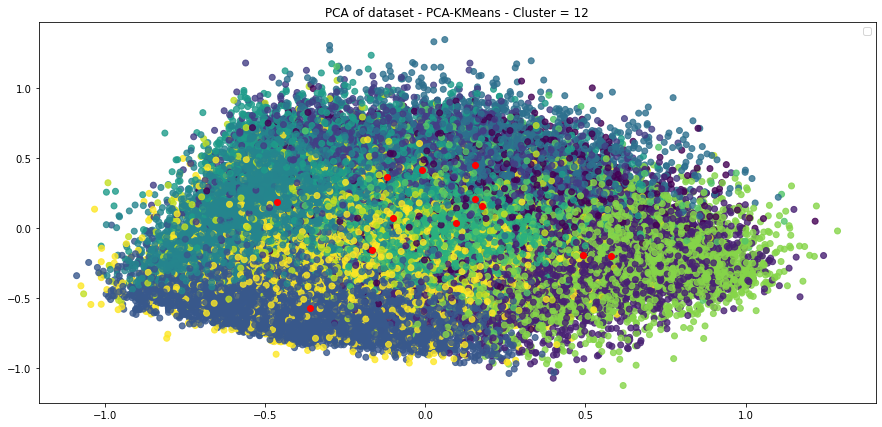

In [31]:
PCA_Visualisation(norm_clients_data, 
                  PCA_cluster, 
                  [list(dic.values()) for dic in PCA_centroid],
                  method = 'PCA-KMeans',
                  threeD = threeD)

In [32]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~648secondes


## Reconstruction des résultats du KMeans A LA MAIN

In [57]:
cluster_correspondance = {0:0, 1:1, 2:2, 3:3, 4:0, 5:1, 6:4,7:5, 8:6, 9:7, 10:0, 11:3, 12:0, 13:8}
new_cluster = []
for c in cluster:
    new_cluster.append(cluster_correspondance[c])
new_cluster_center = [[0 for _ in range(len(cluster_centers[0]))] for _ in range(9)]
cluster_proportion = [0 for _ in range(9)]
for i in range(len(cluster_centers)):
    cluster_proportion[cluster_correspondance[i]] += cluster.tolist().count(i)
    for j in range(len(cluster_centers[i])):
        new_cluster_center[cluster_correspondance[i]][j] += cluster_centers[i][j]*cluster.tolist().count(i)

for i in range(len(new_cluster_center)):
    for j in range(len(new_cluster_center[i])):
        new_cluster_center[i][j] /= cluster_proportion[i]

[[477.54644623041065, 8.291366335784154, 201.0283424278882, 118.1392093757008, 2496.0039520673636, 36.97334273581167, 99.39053818255668, 324.4110598657529, 1103.315388504629, 21.417159428089544, 11.42887189605108, 34.73266200266222, 146.84439941761235, 326.54823225969926, 244.0979280425188, 37.23638512509653, 1114.7171550390617, 211.86204274758947, 459.0011485574654, 97.59879109505893, 6.548653260810966, 774.5262476943159, 71.73953646678414, 415.5019583382918, 10.004167037176096, 48.64944817043059, 229.5864892267165, 22.134418972756166, 70.77507621840783, 426.17963676715516, 44.293914283391075, 460.0000704140035, 88.40647150824228, 1990.085388401618, 37.15279053563009, 566.2588634163949, 564.4343535082253, 53.06630672376608, 158.6018506734474, 31.30822391851664, 22.651464065347675, 279.3759404076106, 33.475689528429974, 27.182590910429525, 111.5166544559224, 3261.308033236996, 78.97809903208626, 19.690542767009706, 14.149151039889816, 151.9330515951991, 177.80988583220613, 163.96479930

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.07575835 0.06477211]
Time Taken to show PCA : ~2secondes


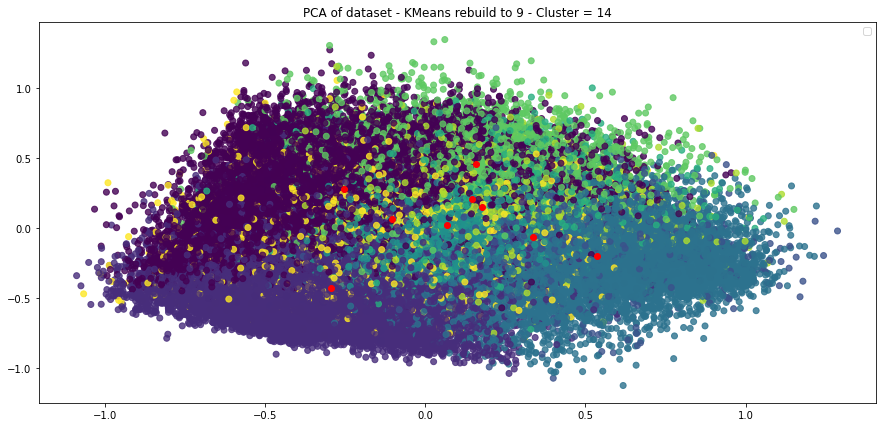

In [62]:
PCA_Visualisation(norm_clients_data, 
                  new_cluster, 
                  new_cluster_center, 
                  method = 'KMeans rebuild to 9', 
                  threeD = threeD)

In [ ]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

In [68]:
# conn = engine.connect()

# for i in range(len(cluster)):
#     sql_cmd = '''UPDATE  ['''+DB+'''].[DWH].[Dim_'''+TABLE_CONSO+''']
#     SET [Segment_Clientele] = ''' + str(cluster_correspondance[cluster[i]]) +''' 
#     WHERE ['''+TABLE_CONSO+'''.KEY] = ''' + str(norm_clients_data.index[i])
    
#     conn.execute(sql_cmd)
    
#     if not i % 1000:
#         print(i*100/len(cluster), "%")
# conn.close()

0.0016845509829354986 %
0.003369101965870997 %
0.005053652948806496 %
0.006738203931741994 %
0.008422754914677493 %
0.010107305897612991 %
0.01179185688054849 %
0.013476407863483988 %
0.015160958846419487 %
0.016845509829354986 %
0.018530060812290482 %
0.020214611795225983 %
0.02189916277816148 %
0.02358371376109698 %
0.025268264744032477 %
0.026952815726967977 %
0.028637366709903474 %
0.030321917692838974 %
0.032006468675774474 %
0.03369101965870997 %
0.03537557064164547 %
0.037060121624580965 %
0.03874467260751647 %
0.040429223590451965 %
0.04211377457338746 %
0.04379832555632296 %
0.04548287653925846 %
0.04716742752219396 %
0.048851978505129456 %
0.05053652948806495 %
0.05222108047100046 %
0.053905631453935954 %
0.05559018243687145 %
0.05727473341980695 %
0.05895928440274245 %
0.06064383538567795 %
0.062328386368613445 %
0.06401293735154895 %
0.06569748833448444 %
0.06738203931741994 %
0.06906659030035545 %
0.07075114128329094 %
0.07243569226622644 %
0.07412024324916193 %
0.07580479

0.6923504539864899 %
0.6940350049694254 %
0.6957195559523609 %
0.6974041069352964 %
0.6990886579182319 %
0.7007732089011673 %
0.7024577598841029 %
0.7041423108670384 %
0.7058268618499739 %
0.7075114128329094 %
0.7091959638158449 %
0.7108805147987803 %
0.7125650657817159 %
0.7142496167646514 %
0.7159341677475869 %
0.7176187187305224 %
0.7193032697134579 %
0.7209878206963933 %
0.7226723716793289 %
0.7243569226622644 %
0.7260414736451999 %
0.7277260246281354 %
0.7294105756110709 %
0.7310951265940063 %
0.7327796775769418 %
0.7344642285598774 %
0.7361487795428129 %
0.7378333305257484 %
0.7395178815086838 %
0.7412024324916193 %
0.7428869834745548 %
0.7445715344574904 %
0.7462560854404259 %
0.7479406364233614 %
0.7496251874062968 %
0.7513097383892323 %
0.7529942893721678 %
0.7546788403551034 %
0.7563633913380389 %
0.7580479423209744 %
0.7597324933039098 %
0.7614170442868453 %
0.7631015952697808 %
0.7647861462527163 %
0.7664706972356519 %
0.7681552482185874 %
0.7698397992015228 %
0.77152435018

1.4234455805804962 %
1.4251301315634317 %
1.4268146825463672 %
1.4284992335293027 %
1.4301837845122383 %
1.4318683354951738 %
1.4335528864781093 %
1.4352374374610448 %
1.4369219884439803 %
1.4386065394269159 %
1.4402910904098511 %
1.4419756413927867 %
1.4436601923757222 %
1.4453447433586577 %
1.4470292943415932 %
1.4487138453245287 %
1.4503983963074643 %
1.4520829472903998 %
1.4537674982733353 %
1.4554520492562708 %
1.4571366002392063 %
1.4588211512221418 %
1.4605057022050771 %
1.4621902531880127 %
1.4638748041709482 %
1.4655593551538837 %
1.4672439061368192 %
1.4689284571197547 %
1.4706130081026902 %
1.4722975590856258 %
1.4739821100685613 %
1.4756666610514968 %
1.4773512120344323 %
1.4790357630173676 %
1.4807203140003031 %
1.4824048649832386 %
1.4840894159661742 %
1.4857739669491097 %
1.4874585179320452 %
1.4891430689149807 %
1.4908276198979162 %
1.4925121708808518 %
1.4941967218637873 %
1.4958812728467228 %
1.4975658238296583 %
1.4992503748125936 %
1.5009349257955291 %
1.50261947677

2.2067617876455032 %
2.2084463386284385 %
2.2101308896113743 %
2.2118154405943096 %
2.2134999915772453 %
2.2151845425601806 %
2.216869093543116 %
2.2185536445260516 %
2.220238195508987 %
2.2219227464919227 %
2.223607297474858 %
2.2252918484577937 %
2.226976399440729 %
2.2286609504236647 %
2.2303455014066 %
2.232030052389536 %
2.233714603372471 %
2.2353991543554064 %
2.237083705338342 %
2.2387682563212774 %
2.240452807304213 %
2.2421373582871484 %
2.243821909270084 %
2.2455064602530195 %
2.247191011235955 %
2.2488755622188905 %
2.2505601132018263 %
2.2522446641847615 %
2.253929215167697 %
2.2556137661506326 %
2.257298317133568 %
2.2589828681165036 %
2.260667419099439 %
2.2623519700823747 %
2.26403652106531 %
2.2657210720482457 %
2.267405623031181 %
2.2690901740141167 %
2.270774724997052 %
2.2724592759799873 %
2.274143826962923 %
2.2758283779458583 %
2.277512928928794 %
2.2791974799117294 %
2.280882030894665 %
2.2825665818776004 %
2.284251132860536 %
2.2859356838434715 %
2.28762023482640

3.274767110826609 %
3.2764516618095447 %
3.27813621279248 %
3.2798207637754158 %
3.281505314758351 %
3.283189865741287 %
3.284874416724222 %
3.286558967707158 %
3.288243518690093 %
3.289928069673029 %
3.291612620655964 %
3.2932971716388995 %
3.294981722621835 %
3.2966662736047705 %
3.2983508245877062 %
3.3000353755706415 %
3.3017199265535773 %
3.3034044775365126 %
3.3050890285194483 %
3.3067735795023836 %
3.3084581304853193 %
3.3101426814682546 %
3.31182723245119 %
3.3135117834341257 %
3.315196334417061 %
3.3168808853999967 %
3.318565436382932 %
3.3202499873658677 %
3.321934538348803 %
3.3236190893317388 %
3.325303640314674 %
3.32698819129761 %
3.328672742280545 %
3.3303572932634804 %
3.332041844246416 %
3.3337263952293514 %
3.335410946212287 %
3.3370954971952225 %
3.338780048178158 %
3.3404645991610935 %
3.3421491501440292 %
3.3438337011269645 %
3.3455182521099003 %
3.3472028030928356 %
3.3488873540757713 %
3.3505719050587066 %
3.352256456041642 %
3.3539410070245776 %
3.35562555800751

4.041237808062261 %
4.042922359045196 %
4.044606910028132 %
4.046291461011068 %
4.047976011994003 %
4.049660562976938 %
4.051345113959874 %
4.05302966494281 %
4.054714215925745 %
4.05639876690868 %
4.058083317891616 %
4.059767868874552 %
4.061452419857487 %
4.063136970840422 %
4.064821521823358 %
4.066506072806294 %
4.068190623789229 %
4.069875174772164 %
4.0715597257551 %
4.073244276738036 %
4.074928827720971 %
4.0766133787039065 %
4.078297929686842 %
4.079982480669777 %
4.081667031652713 %
4.083351582635649 %
4.085036133618584 %
4.086720684601519 %
4.088405235584455 %
4.090089786567391 %
4.091774337550326 %
4.093458888533261 %
4.095143439516197 %
4.096827990499133 %
4.098512541482068 %
4.100197092465003 %
4.101881643447939 %
4.103566194430875 %
4.10525074541381 %
4.106935296396745 %
4.108619847379681 %
4.110304398362617 %
4.111988949345552 %
4.113673500328487 %
4.115358051311423 %
4.117042602294358 %
4.118727153277294 %
4.1204117042602295 %
4.122096255243165 %
4.1237808062261 %
4.125

4.794232097434429 %
4.795916648417364 %
4.7976011994003 %
4.799285750383235 %
4.800970301366171 %
4.802654852349106 %
4.804339403332042 %
4.806023954314977 %
4.807708505297913 %
4.8093930562808485 %
4.811077607263784 %
4.812762158246719 %
4.814446709229655 %
4.8161312602125905 %
4.817815811195526 %
4.819500362178461 %
4.821184913161397 %
4.822869464144333 %
4.8245540151272674 %
4.826238566110203 %
4.827923117093139 %
4.829607668076075 %
4.8312922190590095 %
4.832976770041945 %
4.834661321024881 %
4.836345872007817 %
4.838030422990752 %
4.839714973973687 %
4.841399524956623 %
4.843084075939558 %
4.844768626922494 %
4.846453177905429 %
4.848137728888365 %
4.8498222798713 %
4.851506830854236 %
4.8531913818371715 %
4.854875932820107 %
4.856560483803042 %
4.858245034785978 %
4.8599295857689135 %
4.861614136751848 %
4.863298687734784 %
4.86498323871772 %
4.866667789700656 %
4.8683523406835905 %
4.870036891666526 %
4.871721442649462 %
4.873405993632398 %
4.8750905446153325 %
4.876775095598268

5.5202735710796285 %
5.521958122062564 %
5.5236426730455 %
5.525327224028435 %
5.5270117750113705 %
5.528696325994306 %
5.530380876977242 %
5.532065427960177 %
5.533749978943113 %
5.535434529926048 %
5.537119080908984 %
5.538803631891919 %
5.540488182874855 %
5.54217273385779 %
5.543857284840725 %
5.545541835823661 %
5.547226386806597 %
5.5489109377895325 %
5.550595488772467 %
5.552280039755403 %
5.553964590738339 %
5.5556491417212746 %
5.557333692704209 %
5.559018243687145 %
5.560702794670081 %
5.562387345653017 %
5.5640718966359515 %
5.565756447618887 %
5.567440998601823 %
5.569125549584758 %
5.5708101005676935 %
5.572494651550629 %
5.574179202533565 %
5.5758637535165 %
5.577548304499436 %
5.579232855482371 %
5.580917406465307 %
5.582601957448242 %
5.584286508431178 %
5.585971059414113 %
5.587655610397048 %
5.589340161379984 %
5.59102471236292 %
5.5927092633458555 %
5.59439381432879 %
5.596078365311726 %
5.597762916294662 %
5.599447467277598 %
5.601132018260532 %
5.602816569243468 %


6.2597914525883125 %
6.261476003571248 %
6.263160554554184 %
6.264845105537119 %
6.266529656520055 %
6.26821420750299 %
6.269898758485925 %
6.271583309468861 %
6.273267860451797 %
6.274952411434732 %
6.276636962417667 %
6.278321513400603 %
6.280006064383539 %
6.281690615366474 %
6.283375166349409 %
6.285059717332345 %
6.286744268315281 %
6.288428819298216 %
6.290113370281151 %
6.291797921264087 %
6.293482472247023 %
6.295167023229958 %
6.296851574212893 %
6.298536125195829 %
6.300220676178765 %
6.3019052271617 %
6.3035897781446355 %
6.305274329127571 %
6.306958880110507 %
6.308643431093442 %
6.310327982076378 %
6.312012533059313 %
6.313697084042248 %
6.315381635025184 %
6.31706618600812 %
6.318750736991055 %
6.32043528797399 %
6.322119838956926 %
6.323804389939862 %
6.3254889409227975 %
6.327173491905732 %
6.328858042888668 %
6.330542593871604 %
6.332227144854539 %
6.333911695837474 %
6.33559624682041 %
6.337280797803346 %
6.338965348786281 %
6.3406498997692164 %
6.342334450752152 %
6.

7.0363694557215775 %
7.038054006704513 %
7.039738557687448 %
7.041423108670384 %
7.0431076596533195 %
7.044792210636255 %
7.04647676161919 %
7.048161312602126 %
7.049845863585062 %
7.051530414567997 %
7.053214965550932 %
7.054899516533868 %
7.056584067516804 %
7.0582686184997385 %
7.059953169482674 %
7.06163772046561 %
7.063322271448546 %
7.065006822431481 %
7.066691373414416 %
7.068375924397352 %
7.070060475380288 %
7.071745026363223 %
7.073429577346158 %
7.075114128329094 %
7.076798679312029 %
7.078483230294965 %
7.0801677812779005 %
7.081852332260836 %
7.083536883243771 %
7.085221434226707 %
7.0869059852096425 %
7.088590536192578 %
7.090275087175513 %
7.091959638158449 %
7.093644189141385 %
7.0953287401243195 %
7.097013291107255 %
7.098697842090191 %
7.100382393073127 %
7.1020669440560615 %
7.103751495038997 %
7.105436046021933 %
7.107120597004869 %
7.108805147987804 %
7.110489698970739 %
7.112174249953675 %
7.11385880093661 %
7.115543351919546 %
7.117227902902481 %
7.11891245388541

7.764095480349713 %
7.765780031332648 %
7.767464582315584 %
7.769149133298519 %
7.770833684281455 %
7.77251823526439 %
7.774202786247326 %
7.7758873372302615 %
7.777571888213196 %
7.779256439196132 %
7.780940990179068 %
7.782625541162004 %
7.784310092144938 %
7.785994643127874 %
7.78767919411081 %
7.789363745093746 %
7.7910482960766805 %
7.792732847059616 %
7.794417398042552 %
7.796101949025488 %
7.7977865000084225 %
7.799471050991358 %
7.801155601974294 %
7.802840152957229 %
7.804524703940165 %
7.8062092549231 %
7.807893805906036 %
7.809578356888971 %
7.811262907871907 %
7.812947458854842 %
7.814632009837778 %
7.816316560820713 %
7.818001111803649 %
7.8196856627865845 %
7.821370213769519 %
7.823054764752455 %
7.824739315735391 %
7.826423866718327 %
7.828108417701261 %
7.829792968684197 %
7.831477519667133 %
7.833162070650069 %
7.8348466216330035 %
7.836531172615939 %
7.838215723598875 %
7.83990027458181 %
7.841584825564746 %
7.843269376547681 %
7.844953927530617 %
7.846638478513552 %


8.486767852029041 %
8.488452403011976 %
8.490136953994913 %
8.491821504977848 %
8.493506055960784 %
8.49519060694372 %
8.496875157926654 %
8.49855970890959 %
8.500244259892526 %
8.50192881087546 %
8.503613361858397 %
8.505297912841332 %
8.506982463824267 %
8.508667014807203 %
8.510351565790138 %
8.512036116773075 %
8.51372066775601 %
8.515405218738945 %
8.517089769721881 %
8.518774320704816 %
8.520458871687751 %
8.522143422670688 %
8.523827973653622 %
8.525512524636557 %
8.527197075619494 %
8.528881626602429 %
8.530566177585365 %
8.5322507285683 %
8.533935279551235 %
8.535619830534172 %
8.537304381517107 %
8.538988932500041 %
8.540673483482978 %
8.542358034465913 %
8.544042585448848 %
8.545727136431784 %
8.54741168741472 %
8.549096238397656 %
8.55078078938059 %
8.552465340363526 %
8.554149891346462 %
8.555834442329397 %
8.557518993312332 %
8.559203544295269 %
8.560888095278203 %
8.562572646261138 %
8.564257197244075 %
8.56594174822701 %
8.567626299209946 %
8.569310850192881 %
8.5709954

9.516028502602632 %
9.517713053585567 %
9.519397604568502 %
9.521082155551438 %
9.522766706534373 %
9.524451257517308 %
9.526135808500245 %
9.52782035948318 %
9.529504910466116 %
9.53118946144905 %
9.532874012431986 %
9.534558563414922 %
9.536243114397857 %
9.537927665380792 %
9.539612216363729 %
9.541296767346664 %
9.542981318329598 %
9.544665869312535 %
9.54635042029547 %
9.548034971278407 %
9.549719522261341 %
9.551404073244276 %
9.553088624227213 %
9.554773175210148 %
9.556457726193083 %
9.55814227717602 %
9.559826828158954 %
9.561511379141889 %
9.563195930124825 %
9.56488048110776 %
9.566565032090697 %
9.568249583073632 %
9.569934134056567 %
9.571618685039503 %
9.573303236022438 %
9.574987787005373 %
9.57667233798831 %
9.578356888971244 %
9.58004143995418 %
9.581725990937116 %
9.58341054192005 %
9.585095092902987 %
9.586779643885922 %
9.588464194868857 %
9.590148745851794 %
9.591833296834729 %
9.593517847817663 %
9.5952023988006 %
9.596886949783535 %
9.59857150076647 %
9.600256051

10.235331772316089 %
10.237016323299025 %
10.23870087428196 %
10.240385425264895 %
10.242069976247832 %
10.243754527230767 %
10.245439078213701 %
10.247123629196638 %
10.248808180179573 %
10.250492731162508 %
10.252177282145444 %
10.25386183312838 %
10.255546384111316 %
10.25723093509425 %
10.258915486077186 %
10.260600037060122 %
10.262284588043057 %
10.263969139025992 %
10.265653690008929 %
10.267338240991863 %
10.269022791974798 %
10.270707342957735 %
10.27239189394067 %
10.274076444923606 %
10.275760995906541 %
10.277445546889476 %
10.279130097872413 %
10.280814648855348 %
10.282499199838282 %
10.284183750821219 %
10.285868301804154 %
10.287552852787089 %
10.289237403770025 %
10.29092195475296 %
10.292606505735897 %
10.294291056718832 %
10.295975607701767 %
10.297660158684703 %
10.299344709667638 %
10.301029260650573 %
10.30271381163351 %
10.304398362616444 %
10.30608291359938 %
10.307767464582316 %
10.30945201556525 %
10.311136566548187 %
10.312821117531122 %
10.314505668514057 %


10.932735879251386 %
10.93442043023432 %
10.936104981217257 %
10.937789532200192 %
10.939474083183127 %
10.941158634166063 %
10.942843185148998 %
10.944527736131935 %
10.94621228711487 %
10.947896838097805 %
10.949581389080741 %
10.951265940063676 %
10.952950491046611 %
10.954635042029548 %
10.956319593012482 %
10.958004143995417 %
10.959688694978354 %
10.961373245961289 %
10.963057796944225 %
10.96474234792716 %
10.966426898910095 %
10.968111449893032 %
10.969796000875967 %
10.971480551858901 %
10.973165102841838 %
10.974849653824773 %
10.976534204807708 %
10.978218755790644 %
10.97990330677358 %
10.981587857756516 %
10.98327240873945 %
10.984956959722386 %
10.986641510705322 %
10.988326061688257 %
10.990010612671192 %
10.991695163654128 %
10.993379714637063 %
10.995064265619998 %
10.996748816602935 %
10.99843336758587 %
11.000117918568806 %
11.001802469551741 %
11.003487020534676 %
11.005171571517613 %
11.006856122500547 %
11.008540673483482 %
11.010225224466419 %
11.011909775449354 

11.929990061149201 %
11.931674612132136 %
11.933359163115071 %
11.935043714098008 %
11.936728265080943 %
11.938412816063877 %
11.940097367046814 %
11.941781918029749 %
11.943466469012685 %
11.94515101999562 %
11.946835570978555 %
11.948520121961492 %
11.950204672944427 %
11.951889223927362 %
11.953573774910298 %
11.955258325893233 %
11.956942876876168 %
11.958627427859104 %
11.96031197884204 %
11.961996529824976 %
11.96368108080791 %
11.965365631790846 %
11.967050182773782 %
11.968734733756717 %
11.970419284739652 %
11.972103835722589 %
11.973788386705523 %
11.975472937688458 %
11.977157488671395 %
11.97884203965433 %
11.980526590637266 %
11.982211141620201 %
11.983895692603136 %
11.985580243586073 %
11.987264794569008 %
11.988949345551942 %
11.990633896534879 %
11.992318447517814 %
11.994002998500749 %
11.995687549483685 %
11.99737210046662 %
11.999056651449557 %
12.000741202432492 %
12.002425753415427 %
12.004110304398363 %
12.005794855381298 %
12.007479406364233 %
12.00916395734717 

12.644239677913852 %
12.645924228896787 %
12.647608779879723 %
12.649293330862658 %
12.650977881845595 %
12.65266243282853 %
12.654346983811465 %
12.656031534794401 %
12.657716085777336 %
12.659400636760271 %
12.661085187743208 %
12.662769738726142 %
12.664454289709077 %
12.666138840692014 %
12.667823391674949 %
12.669507942657885 %
12.67119249364082 %
12.672877044623755 %
12.674561595606692 %
12.676246146589627 %
12.677930697572561 %
12.679615248555498 %
12.681299799538433 %
12.682984350521368 %
12.684668901504304 %
12.68635345248724 %
12.688038003470176 %
12.68972255445311 %
12.691407105436046 %
12.693091656418982 %
12.694776207401917 %
12.696460758384852 %
12.698145309367789 %
12.699829860350723 %
12.701514411333658 %
12.703198962316595 %
12.70488351329953 %
12.706568064282466 %
12.708252615265401 %
12.709937166248336 %
12.711621717231273 %
12.713306268214208 %
12.714990819197142 %
12.716675370180079 %
12.718359921163014 %
12.720044472145949 %
12.721729023128885 %
12.72341357411182 

13.328167376985665 %
13.3298519279686 %
13.331536478951536 %
13.333221029934471 %
13.334905580917406 %
13.336590131900342 %
13.338274682883277 %
13.339959233866212 %
13.341643784849149 %
13.343328335832084 %
13.34501288681502 %
13.346697437797955 %
13.34838198878089 %
13.350066539763827 %
13.351751090746761 %
13.353435641729696 %
13.355120192712633 %
13.356804743695568 %
13.358489294678504 %
13.36017384566144 %
13.361858396644374 %
13.36354294762731 %
13.365227498610246 %
13.36691204959318 %
13.368596600576117 %
13.370281151559052 %
13.371965702541987 %
13.373650253524923 %
13.375334804507858 %
13.377019355490795 %
13.37870390647373 %
13.380388457456664 %
13.382073008439601 %
13.383757559422536 %
13.38544211040547 %
13.387126661388407 %
13.388811212371342 %
13.390495763354277 %
13.392180314337214 %
13.393864865320149 %
13.395549416303085 %
13.39723396728602 %
13.398918518268955 %
13.400603069251892 %
13.402287620234826 %
13.403972171217761 %
13.405656722200698 %
13.407341273183633 %
13

14.0036723211428 %
14.005356872125734 %
14.00704142310867 %
14.008725974091606 %
14.01041052507454 %
14.012095076057477 %
14.013779627040412 %
14.015464178023349 %
14.017148729006284 %
14.018833279989218 %
14.020517830972155 %
14.02220238195509 %
14.023886932938025 %
14.025571483920961 %
14.027256034903896 %
14.028940585886831 %
14.030625136869768 %
14.032309687852702 %
14.03399423883564 %
14.035678789818574 %
14.037363340801509 %
14.039047891784445 %
14.04073244276738 %
14.042416993750315 %
14.044101544733252 %
14.045786095716187 %
14.047470646699121 %
14.049155197682058 %
14.050839748664993 %
14.05252429964793 %
14.054208850630864 %
14.0558934016138 %
14.057577952596736 %
14.05926250357967 %
14.060947054562606 %
14.062631605545542 %
14.064316156528477 %
14.066000707511412 %
14.067685258494349 %
14.069369809477283 %
14.07105436046022 %
14.072738911443155 %
14.07442346242609 %
14.076108013409026 %
14.077792564391961 %
14.079477115374896 %
14.081161666357833 %
14.082846217340768 %
14.08

14.68423091824874 %
14.685915469231677 %
14.687600020214612 %
14.689284571197547 %
14.690969122180483 %
14.692653673163418 %
14.694338224146353 %
14.69602277512929 %
14.697707326112225 %
14.69939187709516 %
14.701076428078096 %
14.702760979061031 %
14.704445530043968 %
14.706130081026902 %
14.707814632009837 %
14.709499182992774 %
14.711183733975709 %
14.712868284958644 %
14.71455283594158 %
14.716237386924515 %
14.71792193790745 %
14.719606488890387 %
14.721291039873321 %
14.722975590856258 %
14.724660141839193 %
14.726344692822128 %
14.728029243805064 %
14.729713794788 %
14.731398345770934 %
14.73308289675387 %
14.734767447736806 %
14.73645199871974 %
14.738136549702677 %
14.739821100685612 %
14.741505651668549 %
14.743190202651483 %
14.744874753634418 %
14.746559304617355 %
14.74824385560029 %
14.749928406583225 %
14.751612957566161 %
14.753297508549096 %
14.754982059532031 %
14.756666610514968 %
14.758351161497902 %
14.760035712480839 %
14.761720263463774 %
14.763404814446709 %
14.

15.395111433047521 %
15.396795984030456 %
15.398480535013393 %
15.400165085996328 %
15.401849636979263 %
15.4035341879622 %
15.405218738945134 %
15.406903289928069 %
15.408587840911006 %
15.41027239189394 %
15.411956942876877 %
15.413641493859812 %
15.415326044842747 %
15.417010595825683 %
15.418695146808618 %
15.420379697791553 %
15.42206424877449 %
15.423748799757425 %
15.42543335074036 %
15.427117901723296 %
15.42880245270623 %
15.430487003689167 %
15.432171554672102 %
15.433856105655037 %
15.435540656637974 %
15.437225207620909 %
15.438909758603844 %
15.44059430958678 %
15.442278860569715 %
15.44396341155265 %
15.445647962535586 %
15.447332513518521 %
15.449017064501458 %
15.450701615484393 %
15.452386166467328 %
15.454070717450264 %
15.4557552684332 %
15.457439819416134 %
15.45912437039907 %
15.460808921382005 %
15.46249347236494 %
15.464178023347877 %
15.465862574330812 %
15.467547125313748 %
15.469231676296683 %
15.470916227279618 %
15.472600778262555 %
15.47428532924549 %
15.47

16.073985479170528 %
16.075670030153464 %
16.077354581136397 %
16.079039132119334 %
16.08072368310227 %
16.082408234085204 %
16.08409278506814 %
16.085777336051077 %
16.08746188703401 %
16.089146438016947 %
16.090830988999883 %
16.092515539982816 %
16.094200090965753 %
16.09588464194869 %
16.097569192931623 %
16.09925374391456 %
16.100938294897496 %
16.10262284588043 %
16.104307396863366 %
16.105991947846302 %
16.107676498829235 %
16.109361049812172 %
16.11104560079511 %
16.112730151778045 %
16.11441470276098 %
16.116099253743915 %
16.11778380472685 %
16.119468355709785 %
16.12115290669272 %
16.122837457675658 %
16.12452200865859 %
16.126206559641528 %
16.127891110624464 %
16.129575661607397 %
16.131260212590334 %
16.13294476357327 %
16.134629314556204 %
16.13631386553914 %
16.137998416522077 %
16.13968296750501 %
16.141367518487947 %
16.143052069470883 %
16.144736620453816 %
16.146421171436753 %
16.14810572241969 %
16.149790273402626 %
16.15147482438556 %
16.153159375368496 %
16.15484

17.03081043747789 %
17.032494988460826 %
17.034179539443763 %
17.035864090426696 %
17.037548641409632 %
17.03923319239257 %
17.040917743375502 %
17.04260229435844 %
17.044286845341375 %
17.04597139632431 %
17.047655947307245 %
17.04934049829018 %
17.051025049273115 %
17.05270960025605 %
17.054394151238988 %
17.056078702221924 %
17.057763253204858 %
17.059447804187794 %
17.06113235517073 %
17.062816906153664 %
17.0645014571366 %
17.066186008119537 %
17.06787055910247 %
17.069555110085407 %
17.071239661068343 %
17.072924212051277 %
17.074608763034213 %
17.07629331401715 %
17.077977865000083 %
17.07966241598302 %
17.081346966965956 %
17.08303151794889 %
17.084716068931826 %
17.086400619914762 %
17.088085170897696 %
17.089769721880632 %
17.09145427286357 %
17.093138823846505 %
17.09482337482944 %
17.096507925812375 %
17.09819247679531 %
17.099877027778245 %
17.10156157876118 %
17.103246129744118 %
17.10493068072705 %
17.106615231709988 %
17.108299782692924 %
17.109984333675857 %
17.1116688

17.937098866297188 %
17.938783417280124 %
17.94046796826306 %
17.942152519245994 %
17.94383707022893 %
17.945521621211867 %
17.9472061721948 %
17.948890723177737 %
17.950575274160673 %
17.952259825143607 %
17.953944376126543 %
17.95562892710948 %
17.957313478092413 %
17.95899802907535 %
17.960682580058286 %
17.962367131041223 %
17.964051682024156 %
17.965736233007092 %
17.96742078399003 %
17.969105334972962 %
17.9707898859559 %
17.972474436938835 %
17.97415898792177 %
17.975843538904705 %
17.97752808988764 %
17.979212640870575 %
17.98089719185351 %
17.982581742836448 %
17.98426629381938 %
17.985950844802318 %
17.987635395785254 %
17.989319946768187 %
17.991004497751124 %
17.99268904873406 %
17.994373599716994 %
17.99605815069993 %
17.997742701682867 %
17.999427252665804 %
18.001111803648737 %
18.002796354631673 %
18.00448090561461 %
18.006165456597543 %
18.00785000758048 %
18.009534558563416 %
18.01121910954635 %
18.012903660529286 %
18.014588211512223 %
18.016272762495156 %
18.0179573

18.708623216481648 %
18.71030776746458 %
18.711992318447518 %
18.713676869430454 %
18.715361420413387 %
18.717045971396324 %
18.71873052237926 %
18.720415073362194 %
18.72209962434513 %
18.723784175328067 %
18.725468726311004 %
18.727153277293937 %
18.728837828276873 %
18.73052237925981 %
18.732206930242743 %
18.73389148122568 %
18.735576032208616 %
18.73726058319155 %
18.738945134174486 %
18.740629685157423 %
18.742314236140356 %
18.743998787123292 %
18.74568333810623 %
18.747367889089162 %
18.7490524400721 %
18.750736991055035 %
18.75242154203797 %
18.754106093020905 %
18.75579064400384 %
18.757475194986775 %
18.75915974596971 %
18.760844296952648 %
18.762528847935585 %
18.764213398918518 %
18.765897949901454 %
18.76758250088439 %
18.769267051867324 %
18.77095160285026 %
18.772636153833197 %
18.77432070481613 %
18.776005255799067 %
18.777689806782004 %
18.779374357764937 %
18.781058908747873 %
18.78274345973081 %
18.784428010713743 %
18.78611256169668 %
18.787797112679616 %
18.789481

19.385812711621718 %
19.387497262604654 %
19.389181813587587 %
19.390866364570524 %
19.39255091555346 %
19.394235466536394 %
19.39592001751933 %
19.397604568502267 %
19.3992891194852 %
19.400973670468137 %
19.402658221451073 %
19.404342772434006 %
19.406027323416943 %
19.40771187439988 %
19.409396425382813 %
19.41108097636575 %
19.412765527348686 %
19.41445007833162 %
19.416134629314556 %
19.417819180297492 %
19.41950373128043 %
19.421188282263362 %
19.4228728332463 %
19.424557384229235 %
19.42624193521217 %
19.427926486195105 %
19.42961103717804 %
19.431295588160975 %
19.43298013914391 %
19.434664690126848 %
19.43634924110978 %
19.438033792092718 %
19.439718343075654 %
19.441402894058587 %
19.443087445041524 %
19.44477199602446 %
19.446456547007394 %
19.44814109799033 %
19.449825648973267 %
19.451510199956203 %
19.453194750939137 %
19.454879301922073 %
19.45656385290501 %
19.458248403887943 %
19.45993295487088 %
19.461617505853816 %
19.46330205683675 %
19.464986607819686 %
19.46667115

20.11859238919866 %
20.120276940181594 %
20.12196149116453 %
20.123646042147467 %
20.1253305931304 %
20.127015144113336 %
20.128699695096273 %
20.130384246079206 %
20.132068797062143 %
20.13375334804508 %
20.135437899028013 %
20.13712245001095 %
20.138807000993886 %
20.14049155197682 %
20.142176102959755 %
20.143860653942692 %
20.14554520492563 %
20.147229755908562 %
20.1489143068915 %
20.150598857874435 %
20.152283408857368 %
20.153967959840305 %
20.15565251082324 %
20.157337061806174 %
20.15902161278911 %
20.160706163772048 %
20.16239071475498 %
20.164075265737917 %
20.165759816720854 %
20.167444367703787 %
20.169128918686724 %
20.17081346966966 %
20.172498020652593 %
20.17418257163553 %
20.175867122618467 %
20.1775516736014 %
20.179236224584336 %
20.180920775567273 %
20.18260532655021 %
20.184289877533143 %
20.18597442851608 %
20.187658979499016 %
20.18934353048195 %
20.191028081464886 %
20.192712632447822 %
20.194397183430755 %
20.196081734413692 %
20.19776628539663 %
20.1994508363

20.841264760877987 %
20.842949311860924 %
20.84463386284386 %
20.846318413826793 %
20.84800296480973 %
20.849687515792667 %
20.8513720667756 %
20.853056617758536 %
20.854741168741473 %
20.856425719724406 %
20.858110270707343 %
20.85979482169028 %
20.861479372673212 %
20.86316392365615 %
20.864848474639086 %
20.86653302562202 %
20.868217576604955 %
20.869902127587892 %
20.87158667857083 %
20.87327122955376 %
20.8749557805367 %
20.876640331519635 %
20.878324882502568 %
20.880009433485505 %
20.88169398446844 %
20.883378535451374 %
20.88506308643431 %
20.886747637417248 %
20.88843218840018 %
20.890116739383117 %
20.891801290366054 %
20.893485841348987 %
20.895170392331924 %
20.89685494331486 %
20.898539494297793 %
20.90022404528073 %
20.901908596263667 %
20.9035931472466 %
20.905277698229536 %
20.906962249212473 %
20.90864680019541 %
20.910331351178343 %
20.91201590216128 %
20.913700453144216 %
20.91538500412715 %
20.917069555110086 %
20.918754106093022 %
20.920438657075955 %
20.9221232080

21.590889948284286 %
21.59257449926722 %
21.594259050250155 %
21.595943601233092 %
21.59762815221603 %
21.59931270319896 %
21.600997254181898 %
21.602681805164835 %
21.604366356147768 %
21.606050907130705 %
21.60773545811364 %
21.609420009096574 %
21.61110456007951 %
21.612789111062447 %
21.61447366204538 %
21.616158213028317 %
21.617842764011254 %
21.619527314994187 %
21.621211865977124 %
21.62289641696006 %
21.624580967942993 %
21.62626551892593 %
21.627950069908866 %
21.6296346208918 %
21.631319171874736 %
21.633003722857673 %
21.63468827384061 %
21.636372824823543 %
21.63805737580648 %
21.639741926789416 %
21.64142647777235 %
21.643111028755285 %
21.644795579738222 %
21.646480130721155 %
21.648164681704092 %
21.64984923268703 %
21.65153378366996 %
21.653218334652898 %
21.654902885635835 %
21.656587436618768 %
21.658271987601704 %
21.65995653858464 %
21.661641089567574 %
21.66332564055051 %
21.665010191533447 %
21.66669474251638 %
21.668379293499317 %
21.670063844482254 %
21.6717483

22.561191314455133 %
22.562875865438066 %
22.564560416421003 %
22.56624496740394 %
22.567929518386872 %
22.56961406936981 %
22.571298620352746 %
22.57298317133568 %
22.574667722318615 %
22.576352273301552 %
22.57803682428449 %
22.57972137526742 %
22.58140592625036 %
22.583090477233295 %
22.584775028216228 %
22.586459579199165 %
22.5881441301821 %
22.589828681165034 %
22.59151323214797 %
22.593197783130908 %
22.59488233411384 %
22.596566885096777 %
22.598251436079714 %
22.599935987062647 %
22.601620538045584 %
22.60330508902852 %
22.604989640011453 %
22.60667419099439 %
22.608358741977327 %
22.61004329296026 %
22.611727843943196 %
22.613412394926133 %
22.61509694590907 %
22.616781496892003 %
22.61846604787494 %
22.620150598857876 %
22.62183514984081 %
22.623519700823746 %
22.625204251806682 %
22.626888802789615 %
22.628573353772552 %
22.63025790475549 %
22.63194245573842 %
22.63362700672136 %
22.635311557704295 %
22.636996108687228 %
22.638680659670165 %
22.6403652106531 %
22.6420497616

23.272071829253914 %
23.273756380236847 %
23.275440931219784 %
23.27712548220272 %
23.278810033185653 %
23.28049458416859 %
23.282179135151527 %
23.28386368613446 %
23.285548237117396 %
23.287232788100333 %
23.288917339083266 %
23.290601890066203 %
23.29228644104914 %
23.293970992032072 %
23.29565554301501 %
23.297340093997946 %
23.29902464498088 %
23.300709195963815 %
23.302393746946752 %
23.30407829792969 %
23.30576284891262 %
23.30744739989556 %
23.309131950878495 %
23.310816501861428 %
23.312501052844365 %
23.3141856038273 %
23.315870154810234 %
23.31755470579317 %
23.319239256776108 %
23.32092380775904 %
23.322608358741977 %
23.324292909724914 %
23.325977460707847 %
23.327662011690784 %
23.32934656267372 %
23.331031113656653 %
23.33271566463959 %
23.334400215622527 %
23.33608476660546 %
23.337769317588396 %
23.339453868571333 %
23.34113841955427 %
23.342822970537203 %
23.34450752152014 %
23.346192072503076 %
23.34787662348601 %
23.349561174468946 %
23.351245725451882 %
23.35293027

24.097501810892307 %
24.09918636187524 %
24.100870912858177 %
24.102555463841114 %
24.10424001482405 %
24.105924565806983 %
24.10760911678992 %
24.109293667772857 %
24.11097821875579 %
24.112662769738726 %
24.114347320721663 %
24.116031871704596 %
24.117716422687533 %
24.11940097367047 %
24.121085524653402 %
24.12277007563634 %
24.124454626619276 %
24.12613917760221 %
24.127823728585145 %
24.129508279568082 %
24.131192830551015 %
24.13287738153395 %
24.13456193251689 %
24.13624648349982 %
24.137931034482758 %
24.139615585465695 %
24.14130013644863 %
24.142984687431564 %
24.1446692384145 %
24.146353789397438 %
24.14803834038037 %
24.149722891363307 %
24.151407442346244 %
24.153091993329177 %
24.154776544312114 %
24.15646109529505 %
24.158145646277983 %
24.15983019726092 %
24.161514748243857 %
24.16319929922679 %
24.164883850209726 %
24.166568401192663 %
24.168252952175596 %
24.169937503158533 %
24.17162205414147 %
24.173306605124402 %
24.17499115610734 %
24.176675707090276 %
24.17836025

24.912824486633088 %
24.914509037616025 %
24.916193588598958 %
24.917878139581894 %
24.91956269056483 %
24.921247241547764 %
24.9229317925307 %
24.924616343513637 %
24.92630089449657 %
24.927985445479507 %
24.929669996462444 %
24.931354547445377 %
24.933039098428313 %
24.93472364941125 %
24.936408200394183 %
24.93809275137712 %
24.939777302360056 %
24.941461853342993 %
24.943146404325926 %
24.944830955308863 %
24.9465155062918 %
24.948200057274732 %
24.94988460825767 %
24.951569159240606 %
24.95325371022354 %
24.954938261206475 %
24.956622812189412 %
24.958307363172345 %
24.95999191415528 %
24.96167646513822 %
24.96336101612115 %
24.965045567104088 %
24.966730118087025 %
24.968414669069958 %
24.970099220052894 %
24.97178377103583 %
24.973468322018768 %
24.9751528730017 %
24.976837423984637 %
24.978521974967574 %
24.980206525950507 %
24.981891076933444 %
24.98357562791638 %
24.985260178899313 %
24.98694472988225 %
24.988629280865187 %
24.99031383184812 %
24.991998382831056 %
24.99368293

25.66413422502232 %
25.665818776005256 %
25.667503326988193 %
25.669187877971126 %
25.670872428954063 %
25.672556979937 %
25.674241530919932 %
25.67592608190287 %
25.677610632885806 %
25.67929518386874 %
25.680979734851675 %
25.682664285834612 %
25.684348836817545 %
25.68603338780048 %
25.68771793878342 %
25.68940248976635 %
25.691087040749288 %
25.692771591732225 %
25.694456142715158 %
25.696140693698094 %
25.69782524468103 %
25.699509795663968 %
25.7011943466469 %
25.702878897629837 %
25.704563448612774 %
25.706247999595707 %
25.707932550578644 %
25.70961710156158 %
25.711301652544513 %
25.71298620352745 %
25.714670754510387 %
25.71635530549332 %
25.718039856476256 %
25.719724407459193 %
25.721408958442126 %
25.723093509425063 %
25.724778060408 %
25.726462611390932 %
25.72814716237387 %
25.729831713356806 %
25.73151626433974 %
25.733200815322675 %
25.734885366305612 %
25.73656991728855 %
25.73825446827148 %
25.739939019254418 %
25.741623570237355 %
25.743308121220288 %
25.74499267220

26.45418863601907 %
26.455873187002005 %
26.45755773798494 %
26.459242288967875 %
26.46092683995081 %
26.46261139093375 %
26.46429594191668 %
26.465980492899618 %
26.467665043882555 %
26.469349594865488 %
26.471034145848424 %
26.47271869683136 %
26.474403247814294 %
26.47608779879723 %
26.477772349780167 %
26.4794569007631 %
26.481141451746037 %
26.482826002728974 %
26.484510553711907 %
26.486195104694843 %
26.48787965567778 %
26.489564206660713 %
26.49124875764365 %
26.492933308626586 %
26.49461785960952 %
26.496302410592456 %
26.497986961575393 %
26.49967151255833 %
26.501356063541262 %
26.5030406145242 %
26.504725165507136 %
26.50640971649007 %
26.508094267473005 %
26.509778818455942 %
26.511463369438875 %
26.51314792042181 %
26.51483247140475 %
26.51651702238768 %
26.518201573370618 %
26.519886124353555 %
26.521570675336488 %
26.523255226319424 %
26.52493977730236 %
26.526624328285294 %
26.52830887926823 %
26.529993430251167 %
26.5316779812341 %
26.533362532217037 %
26.535047083199

27.26951131175985 %
27.271195862742786 %
27.272880413725723 %
27.274564964708656 %
27.276249515691593 %
27.27793406667453 %
27.279618617657462 %
27.2813031686404 %
27.282987719623335 %
27.28467227060627 %
27.286356821589205 %
27.288041372572142 %
27.289725923555075 %
27.29141047453801 %
27.293095025520948 %
27.29477957650388 %
27.296464127486818 %
27.298148678469754 %
27.29983322945269 %
27.301517780435624 %
27.30320233141856 %
27.304886882401497 %
27.30657143338443 %
27.308255984367367 %
27.309940535350304 %
27.311625086333237 %
27.313309637316173 %
27.31499418829911 %
27.316678739282043 %
27.31836329026498 %
27.320047841247916 %
27.32173239223085 %
27.323416943213786 %
27.325101494196723 %
27.326786045179656 %
27.328470596162592 %
27.33015514714553 %
27.331839698128462 %
27.3335242491114 %
27.335208800094335 %
27.336893351077272 %
27.338577902060205 %
27.34026245304314 %
27.34194700402608 %
27.34363155500901 %
27.345316105991948 %
27.347000656974885 %
27.348685207957818 %
27.35036975

28.11852500715934 %
28.120209558142278 %
28.12189410912521 %
28.123578660108148 %
28.125263211091085 %
28.126947762074018 %
28.128632313056954 %
28.13031686403989 %
28.132001415022824 %
28.13368596600576 %
28.135370516988697 %
28.137055067971634 %
28.138739618954567 %
28.140424169937504 %
28.14210872092044 %
28.143793271903373 %
28.14547782288631 %
28.147162373869246 %
28.14884692485218 %
28.150531475835116 %
28.152216026818053 %
28.153900577800986 %
28.155585128783922 %
28.15726967976686 %
28.158954230749792 %
28.16063878173273 %
28.162323332715665 %
28.1640078836986 %
28.165692434681535 %
28.167376985664472 %
28.169061536647405 %
28.17074608763034 %
28.172430638613278 %
28.174115189596215 %
28.175799740579148 %
28.177484291562084 %
28.17916884254502 %
28.180853393527954 %
28.18253794451089 %
28.184222495493827 %
28.18590704647676 %
28.187591597459697 %
28.189276148442634 %
28.190960699425567 %
28.192645250408503 %
28.19432980139144 %
28.196014352374373 %
28.19769890335731 %
28.199383

28.95743139666122 %
28.959115947644154 %
28.96080049862709 %
28.962485049610027 %
28.96416960059296 %
28.965854151575897 %
28.967538702558834 %
28.96922325354177 %
28.970907804524703 %
28.97259235550764 %
28.974276906490577 %
28.97596145747351 %
28.977646008456446 %
28.979330559439383 %
28.981015110422316 %
28.982699661405253 %
28.98438421238819 %
28.986068763371122 %
28.98775331435406 %
28.989437865336996 %
28.99112241631993 %
28.992806967302865 %
28.994491518285802 %
28.996176069268735 %
28.99786062025167 %
28.999545171234608 %
29.00122972221754 %
29.002914273200478 %
29.004598824183415 %
29.00628337516635 %
29.007967926149284 %
29.00965247713222 %
29.011337028115157 %
29.01302157909809 %
29.014706130081027 %
29.016390681063964 %
29.018075232046897 %
29.019759783029833 %
29.02144433401277 %
29.023128884995703 %
29.02481343597864 %
29.026497986961576 %
29.02818253794451 %
29.029867088927446 %
29.031551639910383 %
29.033236190893316 %
29.034920741876252 %
29.03660529285919 %
29.0382898

29.78791503124842 %
29.789599582231357 %
29.79128413321429 %
29.792968684197227 %
29.794653235180164 %
29.796337786163097 %
29.798022337146033 %
29.79970688812897 %
29.801391439111903 %
29.80307599009484 %
29.804760541077776 %
29.806445092060713 %
29.808129643043646 %
29.809814194026583 %
29.81149874500952 %
29.813183295992452 %
29.81486784697539 %
29.816552397958326 %
29.81823694894126 %
29.819921499924195 %
29.821606050907132 %
29.823290601890065 %
29.824975152873 %
29.82665970385594 %
29.82834425483887 %
29.830028805821808 %
29.831713356804745 %
29.833397907787678 %
29.835082458770614 %
29.83676700975355 %
29.838451560736484 %
29.84013611171942 %
29.841820662702357 %
29.843505213685294 %
29.845189764668227 %
29.846874315651164 %
29.8485588666341 %
29.850243417617033 %
29.85192796859997 %
29.853612519582907 %
29.85529707056584 %
29.856981621548776 %
29.858666172531713 %
29.860350723514646 %
29.862035274497583 %
29.86371982548052 %
29.865404376463452 %
29.86708892744639 %
29.868773478

30.53754021865472 %
30.539224769637652 %
30.54090932062059 %
30.542593871603525 %
30.54427842258646 %
30.545962973569395 %
30.547647524552332 %
30.549332075535265 %
30.5510166265182 %
30.552701177501138 %
30.55438572848407 %
30.556070279467008 %
30.557754830449944 %
30.559439381432878 %
30.561123932415814 %
30.56280848339875 %
30.564493034381684 %
30.56617758536462 %
30.567862136347557 %
30.569546687330494 %
30.571231238313427 %
30.572915789296363 %
30.5746003402793 %
30.576284891262233 %
30.57796944224517 %
30.579653993228106 %
30.58133854421104 %
30.583023095193976 %
30.584707646176913 %
30.586392197159846 %
30.588076748142782 %
30.58976129912572 %
30.591445850108652 %
30.59313040109159 %
30.594814952074525 %
30.59649950305746 %
30.598184054040395 %
30.59986860502333 %
30.601553156006265 %
30.6032377069892 %
30.604922257972138 %
30.606606808955075 %
30.608291359938008 %
30.609975910920944 %
30.61166046190388 %
30.613345012886814 %
30.61502956386975 %
30.616714114852687 %
30.618398665

31.388238465037144 %
31.38992301602008 %
31.391607567003014 %
31.39329211798595 %
31.394976668968887 %
31.39666121995182 %
31.398345770934757 %
31.400030321917693 %
31.401714872900627 %
31.403399423883563 %
31.4050839748665 %
31.406768525849436 %
31.40845307683237 %
31.410137627815306 %
31.411822178798243 %
31.413506729781176 %
31.415191280764112 %
31.41687583174705 %
31.418560382729982 %
31.42024493371292 %
31.421929484695855 %
31.42361403567879 %
31.425298586661725 %
31.426983137644662 %
31.428667688627595 %
31.43035223961053 %
31.432036790593468 %
31.4337213415764 %
31.435405892559338 %
31.437090443542274 %
31.43877499452521 %
31.440459545508144 %
31.44214409649108 %
31.443828647474017 %
31.44551319845695 %
31.447197749439887 %
31.448882300422824 %
31.450566851405757 %
31.452251402388693 %
31.45393595337163 %
31.455620504354563 %
31.4573050553375 %
31.458989606320436 %
31.46067415730337 %
31.462358708286306 %
31.464043259269243 %
31.465727810252176 %
31.467412361235112 %
31.46909691

32.28441958795883 %
32.28610413894177 %
32.2877886899247 %
32.28947324090763 %
32.29115779189057 %
32.292842342873506 %
32.29452689385644 %
32.29621144483938 %
32.297895995822316 %
32.29958054680525 %
32.30126509778818 %
32.30294964877112 %
32.304634199754055 %
32.30631875073699 %
32.30800330171993 %
32.309687852702865 %
32.311372403685795 %
32.31305695466873 %
32.31474150565167 %
32.316426056634604 %
32.31811060761754 %
32.31979515860048 %
32.32147970958341 %
32.323164260566344 %
32.32484881154928 %
32.32653336253222 %
32.328217913515154 %
32.32990246449809 %
32.33158701548103 %
32.33327156646396 %
32.33495611744689 %
32.33664066842983 %
32.338325219412766 %
32.3400097703957 %
32.34169432137864 %
32.34337887236157 %
32.345063423344506 %
32.34674797432744 %
32.34843252531038 %
32.350117076293316 %
32.35180162727625 %
32.35348617825918 %
32.35517072924212 %
32.356855280225055 %
32.35853983120799 %
32.36022438219093 %
32.361908933173865 %
32.363593484156794 %
32.36527803513973 %
32.36696

33.09468861075081 %
33.09637316173374 %
33.098057712716674 %
33.09974226369961 %
33.10142681468255 %
33.103111365665484 %
33.10479591664842 %
33.10648046763135 %
33.10816501861429 %
33.10984956959722 %
33.11153412058016 %
33.1132186715631 %
33.11490322254603 %
33.11658777352896 %
33.1182723245119 %
33.119956875494836 %
33.12164142647777 %
33.12332597746071 %
33.125010528443646 %
33.126695079426575 %
33.12837963040951 %
33.13006418139245 %
33.131748732375385 %
33.13343328335832 %
33.13511783434126 %
33.136802385324195 %
33.138486936307125 %
33.14017148729006 %
33.141856038273 %
33.143540589255934 %
33.14522514023887 %
33.14690969122181 %
33.14859424220474 %
33.150278793187674 %
33.15196334417061 %
33.15364789515355 %
33.155332446136484 %
33.15701699711942 %
33.15870154810235 %
33.16038609908529 %
33.16207065006822 %
33.16375520105116 %
33.165439752034096 %
33.16712430301703 %
33.16880885399997 %
33.1704934049829 %
33.172177955965836 %
33.17386250694877 %
33.17554705793171 %
33.177231608

33.91001128649159 %
33.91169583747452 %
33.913380388457455 %
33.91506493944039 %
33.91674949042333 %
33.918434041406265 %
33.9201185923892 %
33.92180314337213 %
33.92348769435507 %
33.925172245338004 %
33.92685679632094 %
33.92854134730388 %
33.930225898286814 %
33.93191044926975 %
33.93359500025268 %
33.93527955123562 %
33.93696410221855 %
33.93864865320149 %
33.94033320418443 %
33.94201775516736 %
33.94370230615029 %
33.94538685713323 %
33.947071408116166 %
33.9487559590991 %
33.95044051008204 %
33.952125061064976 %
33.953809612047905 %
33.95549416303084 %
33.95717871401378 %
33.958863264996715 %
33.96054781597965 %
33.96223236696259 %
33.963916917945525 %
33.965601468928455 %
33.96728601991139 %
33.96897057089433 %
33.970655121877265 %
33.9723396728602 %
33.97402422384314 %
33.97570877482607 %
33.977393325809004 %
33.97907787679194 %
33.98076242777488 %
33.982446978757814 %
33.98413152974075 %
33.98581608072368 %
33.98750063170662 %
33.98918518268955 %
33.99086973367249 %
33.9925542

34.68322018765898 %
34.68490473864191 %
34.68658928962485 %
34.688273840607785 %
34.68995839159072 %
34.69164294257366 %
34.693327493556595 %
34.69501204453953 %
34.69669659552246 %
34.6983811465054 %
34.700065697488334 %
34.70175024847127 %
34.70343479945421 %
34.705119350437144 %
34.70680390142007 %
34.70848845240301 %
34.71017300338595 %
34.71185755436888 %
34.71354210535182 %
34.71522665633476 %
34.716911207317686 %
34.71859575830062 %
34.72028030928356 %
34.721964860266496 %
34.72364941124943 %
34.72533396223237 %
34.727018513215306 %
34.728703064198235 %
34.73038761518117 %
34.73207216616411 %
34.733756717147045 %
34.73544126812998 %
34.73712581911292 %
34.73881037009585 %
34.740494921078785 %
34.74217947206172 %
34.74386402304466 %
34.745548574027595 %
34.74723312501053 %
34.74891767599346 %
34.7506022269764 %
34.752286777959334 %
34.75397132894227 %
34.75565587992521 %
34.757340430908144 %
34.75902498189107 %
34.76070953287401 %
34.76239408385695 %
34.76407863483988 %
34.765763

35.51033472028031 %
35.51201927126324 %
35.51370382224618 %
35.515388373229115 %
35.51707292421205 %
35.51875747519499 %
35.520442026177925 %
35.522126577160854 %
35.52381112814379 %
35.52549567912673 %
35.527180230109664 %
35.5288647810926 %
35.53054933207554 %
35.532233883058474 %
35.533918434041404 %
35.53560298502434 %
35.53728753600728 %
35.53897208699021 %
35.54065663797315 %
35.54234118895609 %
35.544025739939016 %
35.54571029092195 %
35.54739484190489 %
35.549079392887826 %
35.55076394387076 %
35.5524484948537 %
35.55413304583663 %
35.555817596819566 %
35.5575021478025 %
35.55918669878544 %
35.560871249768375 %
35.56255580075131 %
35.56424035173425 %
35.56592490271718 %
35.567609453700115 %
35.56929400468305 %
35.57097855566599 %
35.572663106648925 %
35.57434765763186 %
35.57603220861479 %
35.57771675959773 %
35.579401310580664 %
35.5810858615636 %
35.58277041254654 %
35.584454963529474 %
35.5861395145124 %
35.58782406549534 %
35.58950861647828 %
35.59119316746121 %
35.59287771

36.349241109782184 %
36.35092566076512 %
36.35261021174806 %
36.354294762730994 %
36.35597931371393 %
36.35766386469687 %
36.3593484156798 %
36.361032966662734 %
36.36271751764567 %
36.36440206862861 %
36.36608661961154 %
36.36777117059448 %
36.36945572157742 %
36.371140272560346 %
36.37282482354328 %
36.37450937452622 %
36.376193925509156 %
36.37787847649209 %
36.37956302747503 %
36.38124757845796 %
36.382932129440896 %
36.38461668042383 %
36.38630123140677 %
36.387985782389705 %
36.38967033337264 %
36.39135488435557 %
36.39303943533851 %
36.394723986321445 %
36.39640853730438 %
36.39809308828732 %
36.399777639270255 %
36.40146219025319 %
36.40314674123612 %
36.40483129221906 %
36.406515843201994 %
36.40820039418493 %
36.40988494516787 %
36.411569496150804 %
36.413254047133734 %
36.41493859811667 %
36.41662314909961 %
36.41830770008254 %
36.41999225106548 %
36.42167680204842 %
36.423361353031346 %
36.42504590401428 %
36.42673045499722 %
36.428415005980156 %
36.43009955696309 %
36.4317

37.240368579755064 %
37.242053130738 %
37.24373768172094 %
37.24542223270387 %
37.24710678368681 %
37.24879133466975 %
37.250475885652676 %
37.25216043663561 %
37.25384498761855 %
37.255529538601486 %
37.25721408958442 %
37.25889864056736 %
37.26058319155029 %
37.262267742533226 %
37.26395229351616 %
37.2656368444991 %
37.267321395482035 %
37.26900594646497 %
37.27069049744791 %
37.27237504843084 %
37.274059599413775 %
37.27574415039671 %
37.27742870137965 %
37.279113252362585 %
37.28079780334552 %
37.28248235432845 %
37.28416690531139 %
37.285851456294324 %
37.28753600727726 %
37.2892205582602 %
37.290905109243134 %
37.292589660226064 %
37.294274211209 %
37.29595876219194 %
37.29764331317487 %
37.29932786415781 %
37.30101241514075 %
37.302696966123676 %
37.30438151710661 %
37.30606606808955 %
37.307750619072486 %
37.30943517005542 %
37.31111972103836 %
37.312804272021296 %
37.314488823004226 %
37.31617337398716 %
37.3178579249701 %
37.319542475953035 %
37.32122702693597 %
37.322911577

37.99336286912723 %
37.99504742011017 %
37.996731971093105 %
37.99841652207604 %
38.00010107305898 %
38.001785624041915 %
38.003470175024844 %
38.00515472600778 %
38.00683927699072 %
38.008523827973654 %
38.01020837895659 %
38.01189292993953 %
38.01357748092246 %
38.015262031905394 %
38.01694658288833 %
38.01863113387127 %
38.020315684854204 %
38.02200023583714 %
38.02368478682007 %
38.025369337803006 %
38.02705388878594 %
38.02873843976888 %
38.030422990751816 %
38.03210754173475 %
38.03379209271769 %
38.03547664370062 %
38.037161194683556 %
38.03884574566649 %
38.04053029664943 %
38.042214847632366 %
38.0438993986153 %
38.04558394959823 %
38.04726850058117 %
38.048953051564105 %
38.05063760254704 %
38.05232215352998 %
38.054006704512915 %
38.055691255495844 %
38.05737580647878 %
38.05906035746172 %
38.060744908444654 %
38.06242945942759 %
38.06411401041053 %
38.06579856139346 %
38.067483112376394 %
38.06916766335933 %
38.07085221434227 %
38.072536765325204 %
38.07422131630814 %
38.07

38.72108889375537 %
38.72277344473831 %
38.72445799572124 %
38.726142546704175 %
38.72782709768711 %
38.72951164867005 %
38.731196199652985 %
38.73288075063592 %
38.73456530161885 %
38.73624985260179 %
38.737934403584724 %
38.73961895456766 %
38.7413035055506 %
38.742988056533534 %
38.7463571584994 %
38.74804170948234 %
38.74972626046527 %
38.75141081144821 %
38.75309536243115 %
38.754779913414076 %
38.75646446439701 %
38.75814901537995 %
38.759833566362886 %
38.76151811734582 %
38.76320266832876 %
38.764887219311696 %
38.766571770294625 %
38.76825632127756 %
38.7699408722605 %
38.771625423243435 %
38.77330997422637 %
38.77499452520931 %
38.77667907619224 %
38.778363627175175 %
38.78004817815811 %
38.78173272914105 %
38.783417280123984 %
38.78510183110692 %
38.78678638208985 %
38.78847093307279 %
38.790155484055724 %
38.79184003503866 %
38.7935245860216 %
38.795209137004534 %
38.79689368798747 %
38.7985782389704 %
38.80026278995334 %
38.80194734093627 %
38.80363189191921 %
38.805316442

39.41343934774186 %
39.415123898724794 %
39.41680844970773 %
39.41849300069067 %
39.4201775516736 %
39.42186210265654 %
39.42354665363947 %
39.425231204622406 %
39.42691575560534 %
39.42860030658828 %
39.430284857571216 %
39.43196940855415 %
39.43365395953708 %
39.43533851052002 %
39.437023061502956 %
39.43870761248589 %
39.44039216346883 %
39.442076714451765 %
39.443761265434695 %
39.44544581641763 %
39.44713036740057 %
39.448814918383505 %
39.45049946936644 %
39.45218402034938 %
39.453868571332315 %
39.455553122315244 %
39.45723767329818 %
39.45892222428112 %
39.460606775264054 %
39.46229132624699 %
39.46397587722993 %
39.46566042821286 %
39.46734497919579 %
39.46902953017873 %
39.47071408116167 %
39.4723986321446 %
39.47408318312754 %
39.47576773411047 %
39.477452285093406 %
39.47913683607634 %
39.48082138705928 %
39.482505938042216 %
39.48419048902515 %
39.48587504000809 %
39.48755959099102 %
39.489244141973955 %
39.49092869295689 %
39.49261324393983 %
39.494297794922765 %
39.49598

40.22876202348264 %
40.230446574465574 %
40.23213112544851 %
40.23381567643145 %
40.235500227414384 %
40.23718477839732 %
40.23886932938025 %
40.24055388036319 %
40.242238431346124 %
40.24392298232906 %
40.245607533312 %
40.24729208429493 %
40.24897663527787 %
40.2506611862608 %
40.252345737243736 %
40.25403028822667 %
40.25571483920961 %
40.257399390192546 %
40.25908394117548 %
40.26076849215841 %
40.26245304314135 %
40.264137594124286 %
40.26582214510722 %
40.26750669609016 %
40.269191247073095 %
40.270875798056025 %
40.27256034903896 %
40.2742449000219 %
40.275929451004835 %
40.27761400198777 %
40.27929855297071 %
40.28098310395364 %
40.282667654936574 %
40.28435220591951 %
40.28603675690245 %
40.287721307885384 %
40.28940585886832 %
40.29109040985126 %
40.29277496083419 %
40.294459511817124 %
40.29614406280006 %
40.297828613783 %
40.29951316476593 %
40.30119771574887 %
40.3028822667318 %
40.304566817714736 %
40.30625136869767 %
40.30793591968061 %
40.309620470663546 %
40.3113050216

41.103043983626165 %
41.1047285346091 %
41.10641308559204 %
41.10809763657497 %
41.109782187557904 %
41.11146673854084 %
41.11315128952378 %
41.114835840506714 %
41.11652039148965 %
41.11820494247258 %
41.11988949345552 %
41.121574044438454 %
41.12325859542139 %
41.12494314640433 %
41.12662769738726 %
41.1283122483702 %
41.12999679935313 %
41.131681350336066 %
41.133365901319 %
41.13505045230194 %
41.136735003284876 %
41.13841955426781 %
41.14010410525074 %
41.14178865623368 %
41.143473207216616 %
41.14515775819955 %
41.14684230918249 %
41.148526860165425 %
41.150211411148355 %
41.15189596213129 %
41.15358051311423 %
41.155265064097165 %
41.1569496150801 %
41.15863416606304 %
41.160318717045975 %
41.162003268028904 %
41.16368781901184 %
41.16537236999478 %
41.167056920977714 %
41.16874147196065 %
41.17042602294359 %
41.17211057392652 %
41.173795124909454 %
41.17547967589239 %
41.17716422687533 %
41.17884877785826 %
41.1805333288412 %
41.18221787982413 %
41.183902430807066 %
41.18558698

41.99080235163317 %
41.99248690261611 %
41.994171453599044 %
41.99585600458198 %
41.99754055556492 %
41.99922510654785 %
42.000909657530784 %
42.00259420851372 %
42.00427875949666 %
42.00596331047959 %
42.00764786146253 %
42.00933241244546 %
42.011016963428396 %
42.01270151441133 %
42.01438606539427 %
42.016070616377206 %
42.01775516736014 %
42.01943971834307 %
42.02112426932601 %
42.022808820308946 %
42.02449337129188 %
42.02617792227482 %
42.027862473257755 %
42.02954702424069 %
42.03123157522362 %
42.03291612620656 %
42.034600677189495 %
42.03628522817243 %
42.03796977915537 %
42.039654330138305 %
42.041338881121234 %
42.04302343210417 %
42.04470798308711 %
42.046392534070044 %
42.04807708505298 %
42.04976163603592 %
42.05144618701885 %
42.053130738001784 %
42.05481528898472 %
42.05649983996766 %
42.05818439095059 %
42.05986894193353 %
42.06155349291646 %
42.063238043899396 %
42.06492259488233 %
42.06660714586527 %
42.068291696848206 %
42.06997624783114 %
42.07166079881408 %
42.0733

42.83644694506679 %
42.838131496049726 %
42.83981604703266 %
42.8415005980156 %
42.843185148998536 %
42.84486969998147 %
42.8465542509644 %
42.84823880194734 %
42.849923352930276 %
42.85160790391321 %
42.85329245489615 %
42.854977005879086 %
42.856661556862015 %
42.85834610784495 %
42.86003065882789 %
42.861715209810825 %
42.86339976079376 %
42.8650843117767 %
42.866768862759635 %
42.868453413742564 %
42.8701379647255 %
42.87182251570844 %
42.873507066691374 %
42.87519161767431 %
42.87687616865725 %
42.87856071964018 %
42.880245270623114 %
42.88192982160605 %
42.88361437258899 %
42.88529892357192 %
42.88698347455486 %
42.88866802553779 %
42.890352576520726 %
42.89203712750366 %
42.8937216784866 %
42.895406229469536 %
42.89709078045247 %
42.89877533143541 %
42.90045988241834 %
42.902144433401276 %
42.90382898438421 %
42.90551353536715 %
42.907198086350085 %
42.90888263733302 %
42.91056718831595 %
42.91225173929889 %
42.913936290281825 %
42.91562084126476 %
42.9173053922477 %
42.91898994

43.69893704832977 %
43.700621599312704 %
43.70230615029564 %
43.70399070127858 %
43.70567525226151 %
43.707359803244444 %
43.70904435422738 %
43.71072890521032 %
43.712413456193254 %
43.71409800717619 %
43.71578255815912 %
43.717467109142056 %
43.71915166012499 %
43.72083621110793 %
43.722520762090866 %
43.7242053130738 %
43.72588986405673 %
43.72757441503967 %
43.729258966022606 %
43.73094351700554 %
43.73262806798848 %
43.734312618971416 %
43.73599716995435 %
43.73768172093728 %
43.73936627192022 %
43.741050822903155 %
43.74273537388609 %
43.74441992486903 %
43.746104475851965 %
43.747789026834894 %
43.74947357781783 %
43.75115812880077 %
43.752842679783704 %
43.75452723076664 %
43.75621178174958 %
43.75789633273251 %
43.759580883715444 %
43.76126543469838 %
43.76294998568132 %
43.76463453666425 %
43.76631908764719 %
43.76800363863012 %
43.769688189613056 %
43.77137274059599 %
43.77305729157893 %
43.774741842561866 %
43.7764263935448 %
43.77811094452774 %
43.77979549551067 %
43.78148

44.446877684753126 %
44.44856223573606 %
44.450246786719 %
44.451931337701936 %
44.45361588868487 %
44.45530043966781 %
44.45698499065074 %
44.458669541633675 %
44.46035409261661 %
44.46203864359955 %
44.463723194582485 %
44.46540774556542 %
44.46709229654836 %
44.46877684753129 %
44.470461398514225 %
44.47214594949716 %
44.4738305004801 %
44.475515051463034 %
44.47719960244597 %
44.4788841534289 %
44.48056870441184 %
44.482253255394774 %
44.48393780637771 %
44.48562235736065 %
44.487306908343584 %
44.48899145932651 %
44.49067601030945 %
44.49236056129239 %
44.49404511227532 %
44.49572966325826 %
44.497414214241196 %
44.49909876522413 %
44.50078331620706 %
44.50246786719 %
44.504152418172936 %
44.50583696915587 %
44.50752152013881 %
44.509206071121746 %
44.510890622104675 %
44.51257517308761 %
44.51425972407055 %
44.515944275053485 %
44.51762882603642 %
44.51931337701936 %
44.52099792800229 %
44.522682478985224 %
44.52436702996816 %
44.5260515809511 %
44.527736131934034 %
44.5294206829

45.27062311540859 %
45.27230766639153 %
45.273992217374456 %
45.27567676835739 %
45.27736131934033 %
45.279045870323266 %
45.2807304213062 %
45.28241497228914 %
45.28409952327207 %
45.285784074255005 %
45.28746862523794 %
45.28915317622088 %
45.290837727203815 %
45.29252227818675 %
45.29420682916968 %
45.29589138015262 %
45.297575931135555 %
45.29926048211849 %
45.30094503310143 %
45.302629584084364 %
45.3043141350673 %
45.30599868605023 %
45.30768323703317 %
45.309367788016104 %
45.31105233899904 %
45.31273688998198 %
45.314421440964914 %
45.31610599194784 %
45.31779054293078 %
45.31947509391372 %
45.32115964489665 %
45.32284419587959 %
45.324528746862526 %
45.326213297845456 %
45.32789784882839 %
45.32958239981133 %
45.331266950794266 %
45.3329515017772 %
45.33463605276014 %
45.336320603743076 %
45.338005154726005 %
45.33968970570894 %
45.34137425669188 %
45.343058807674815 %
45.34474335865775 %
45.34642790964069 %
45.34811246062362 %
45.349797011606555 %
45.35148156258949 %
45.35316

45.962973569395075 %
45.96465812037801 %
45.96634267136095 %
45.968027222343885 %
45.96971177332682 %
45.97139632430976 %
45.97308087529269 %
45.974765426275624 %
45.97644997725856 %
45.9781345282415 %
45.979819079224434 %
45.98150363020737 %
45.9831881811903 %
45.98487273217324 %
45.98655728315617 %
45.98824183413911 %
45.98992638512205 %
45.99161093610498 %
45.99329548708792 %
45.99498003807085 %
45.996664589053786 %
45.99834914003672 %
46.00003369101966 %
46.001718242002596 %
46.00340279298553 %
46.00508734396846 %
46.0067718949514 %
46.008456445934335 %
46.01014099691727 %
46.01182554790021 %
46.013510098883145 %
46.015194649866075 %
46.01687920084901 %
46.01856375183195 %
46.020248302814885 %
46.02193285379782 %
46.02361740478076 %
46.025301955763695 %
46.026986506746624 %
46.02867105772956 %
46.0303556087125 %
46.032040159695434 %
46.03372471067837 %
46.03540926166131 %
46.03709381264424 %
46.03877836362717 %
46.04046291461011 %
46.04214746559305 %
46.04383201657598 %
46.04551656

46.71765240975018 %
46.719336960733116 %
46.72102151171605 %
46.72270606269899 %
46.724390613681926 %
46.726075164664856 %
46.72775971564779 %
46.72944426663073 %
46.731128817613666 %
46.7328133685966 %
46.73449791957954 %
46.73618247056247 %
46.737867021545405 %
46.73955157252834 %
46.74123612351128 %
46.742920674494215 %
46.74460522547715 %
46.74628977646008 %
46.74797432744302 %
46.749658878425954 %
46.75134342940889 %
46.75302798039183 %
46.754712531374764 %
46.7563970823577 %
46.75808163334063 %
46.75976618432357 %
46.761450735306504 %
46.76313528628944 %
46.76481983727238 %
46.76650438825531 %
46.76818893923824 %
46.76987349022118 %
46.771558041204116 %
46.77324259218705 %
46.77492714316999 %
46.776611694152926 %
46.778296245135856 %
46.77998079611879 %
46.78166534710173 %
46.783349898084666 %
46.7850344490676 %
46.78671900005054 %
46.788403551033475 %
46.790088102016405 %
46.79177265299934 %
46.79345720398228 %
46.795141754965215 %
46.79682630594815 %
46.79851085693109 %
46.8001

47.53971328942271 %
47.54139784040564 %
47.54308239138857 %
47.54476694237151 %
47.546451493354446 %
47.54813604433738 %
47.54982059532032 %
47.551505146303256 %
47.553189697286186 %
47.55487424826912 %
47.55655879925206 %
47.558243350234996 %
47.55992790121793 %
47.56161245220087 %
47.5632970031838 %
47.564981554166735 %
47.56666610514967 %
47.56835065613261 %
47.570035207115545 %
47.57171975809848 %
47.57340430908141 %
47.57508886006435 %
47.576773411047284 %
47.57845796203022 %
47.58014251301316 %
47.581827063996094 %
47.583511614979024 %
47.58519616596196 %
47.5868807169449 %
47.588565267927834 %
47.59024981891077 %
47.59193436989371 %
47.593618920876644 %
47.59530347185957 %
47.59698802284251 %
47.598672573825446 %
47.60035712480838 %
47.60204167579132 %
47.603726226774256 %
47.605410777757186 %
47.60709532874012 %
47.60877987972306 %
47.610464430705996 %
47.61214898168893 %
47.61383353267187 %
47.6155180836548 %
47.617202634637735 %
47.61888718562067 %
47.62057173660361 %
47.6222

48.31629129255597 %
48.3179758435389 %
48.31966039452184 %
48.32134494550478 %
48.32302949648771 %
48.32471404747065 %
48.32639859845358 %
48.328083149436516 %
48.32976770041945 %
48.33145225140239 %
48.333136802385326 %
48.33482135336826 %
48.33650590435119 %
48.33819045533413 %
48.339875006317065 %
48.3415595573 %
48.34324410828294 %
48.344928659265875 %
48.346613210248805 %
48.34829776123174 %
48.34998231221468 %
48.351666863197615 %
48.35335141418055 %
48.35503596516349 %
48.356720516146424 %
48.358405067129354 %
48.36008961811229 %
48.36177416909523 %
48.363458720078164 %
48.3651432710611 %
48.36682782204404 %
48.36851237302697 %
48.3701969240099 %
48.37188147499284 %
48.37356602597578 %
48.37525057695871 %
48.37693512794165 %
48.37861967892458 %
48.380304229907516 %
48.38198878089045 %
48.38367333187339 %
48.385357882856326 %
48.38704243383926 %
48.3887269848222 %
48.39041153580513 %
48.392096086788065 %
48.393780637771 %
48.39546518875394 %
48.397149739736875 %
48.39883429071981

49.13666762124556 %
49.138352172228494 %
49.14003672321143 %
49.14172127419436 %
49.1434058251773 %
49.14509037616023 %
49.14677492714317 %
49.14845947812611 %
49.15014402910904 %
49.15182858009198 %
49.15351313107491 %
49.155197682057846 %
49.15688223304078 %
49.15856678402372 %
49.160251335006656 %
49.16193588598959 %
49.16362043697252 %
49.16530498795546 %
49.166989538938395 %
49.16867408992133 %
49.17035864090427 %
49.172043191887205 %
49.173727742870135 %
49.17541229385307 %
49.17709684483601 %
49.178781395818945 %
49.18046594680188 %
49.18215049778482 %
49.183835048767754 %
49.185519599750684 %
49.18720415073362 %
49.18888870171656 %
49.190573252699494 %
49.19225780368243 %
49.19394235466537 %
49.1956269056483 %
49.19731145663123 %
49.19899600761417 %
49.20068055859711 %
49.20236510958004 %
49.20404966056298 %
49.20573421154591 %
49.207418762528846 %
49.20910331351178 %
49.21078786449472 %
49.212472415477656 %
49.21415696646059 %
49.21584151744352 %
49.21752606842646 %
49.2192106

49.98062766369624 %
49.982312214679176 %
49.98399676566211 %
49.98568131664505 %
49.987365867627986 %
49.98905041861092 %
49.99073496959385 %
49.99241952057679 %
49.994104071559725 %
49.99578862254266 %
49.9974731735256 %
49.999157724508535 %
50.000842275491465 %
50.0025268264744 %
50.00421137745734 %
50.005895928440275 %
50.00758047942321 %
50.00926503040615 %
50.01094958138908 %
50.012634132372014 %
50.01431868335495 %
50.01600323433789 %
50.017687785320824 %
50.01937233630376 %
50.0210568872867 %
50.02274143826963 %
50.02442598925256 %
50.0261105402355 %
50.02779509121844 %
50.02947964220137 %
50.03116419318431 %
50.03284874416724 %
50.034533295150176 %
50.03621784613311 %
50.03790239711605 %
50.039586948098986 %
50.04127149908192 %
50.04295605006485 %
50.04464060104779 %
50.046325152030725 %
50.04800970301366 %
50.0496942539966 %
50.051378804979535 %
50.053063355962465 %
50.0547479069454 %
50.05643245792834 %
50.058117008911275 %
50.05980155989421 %
50.06148611087715 %
50.063170661

50.79595033943702 %
50.79763489041996 %
50.79931944140289 %
50.80100399238583 %
50.80268854336877 %
50.8043730943517 %
50.80605764533463 %
50.80774219631757 %
50.809426747300506 %
50.81111129828344 %
50.81279584926638 %
50.814480400249316 %
50.816164951232246 %
50.81784950221518 %
50.81953405319812 %
50.821218604181055 %
50.82290315516399 %
50.82458770614693 %
50.826272257129865 %
50.827956808112795 %
50.82964135909573 %
50.83132591007867 %
50.833010461061605 %
50.83469501204454 %
50.83637956302748 %
50.83806411401041 %
50.839748664993344 %
50.84143321597628 %
50.84311776695922 %
50.844802317942154 %
50.84648686892509 %
50.84817141990802 %
50.84985597089096 %
50.85154052187389 %
50.85322507285683 %
50.85490962383977 %
50.8565941748227 %
50.85827872580564 %
50.85996327678857 %
50.861647827771506 %
50.86333237875444 %
50.86501692973738 %
50.866701480720316 %
50.86838603170325 %
50.87007058268618 %
50.87175513366912 %
50.873439684652055 %
50.87512423563499 %
50.87680878661793 %
50.8784933

51.569159240604414 %
51.57084379158735 %
51.57252834257029 %
51.574212893553224 %
51.57589744453616 %
51.5775819955191 %
51.579266546502026 %
51.58095109748496 %
51.5826356484679 %
51.584320199450836 %
51.58600475043377 %
51.58768930141671 %
51.589373852399646 %
51.591058403382576 %
51.59274295436551 %
51.59442750534845 %
51.596112056331386 %
51.59779660731432 %
51.59948115829726 %
51.60116570928019 %
51.602850260263125 %
51.60453481124606 %
51.606219362229 %
51.607903913211935 %
51.60958846419487 %
51.6112730151778 %
51.61295756616074 %
51.614642117143674 %
51.61632666812661 %
51.61801121910955 %
51.619695770092484 %
51.62138032107542 %
51.62306487205835 %
51.62474942304129 %
51.62643397402422 %
51.62811852500716 %
51.6298030759901 %
51.63148762697303 %
51.63317217795596 %
51.6348567289389 %
51.636541279921836 %
51.63822583090477 %
51.63991038188771 %
51.641594932870646 %
51.643279483853576 %
51.64496403483651 %
51.64664858581945 %
51.648333136802385 %
51.65001768778532 %
51.651702238

52.31541532604484 %
52.31709987702778 %
52.318784428010716 %
52.32046897899365 %
52.32215352997658 %
52.32383808095952 %
52.325522631942455 %
52.32720718292539 %
52.32889173390833 %
52.330576284891265 %
52.332260835874195 %
52.33394538685713 %
52.33562993784007 %
52.337314488823004 %
52.33899903980594 %
52.34068359078888 %
52.34236814177181 %
52.344052692754744 %
52.34573724373768 %
52.34742179472062 %
52.349106345703554 %
52.35079089668649 %
52.35247544766943 %
52.35415999865236 %
52.35584454963529 %
52.35752910061823 %
52.359213651601166 %
52.3608982025841 %
52.36258275356704 %
52.36426730454997 %
52.365951855532906 %
52.36763640651584 %
52.36932095749878 %
52.371005508481716 %
52.37269005946465 %
52.37437461044758 %
52.37605916143052 %
52.377743712413455 %
52.37942826339639 %
52.38111281437933 %
52.382797365362265 %
52.3844819163452 %
52.38616646732813 %
52.38785101831107 %
52.389535569294004 %
52.39122012027694 %
52.39290467125988 %
52.394589222242814 %
52.396273773225744 %
52.3979

53.095362431143975 %
53.09704698212691 %
53.09873153310985 %
53.100416084092785 %
53.10210063507572 %
53.10378518605866 %
53.10546973704159 %
53.107154288024525 %
53.10883883900746 %
53.1105233899904 %
53.112207940973335 %
53.11389249195627 %
53.11557704293921 %
53.11726159392214 %
53.118946144905074 %
53.12063069588801 %
53.12231524687095 %
53.123999797853884 %
53.12568434883682 %
53.12736889981975 %
53.12905345080269 %
53.13073800178562 %
53.13242255276856 %
53.1341071037515 %
53.13579165473443 %
53.13747620571736 %
53.1391607567003 %
53.140845307683236 %
53.14252985866617 %
53.14421440964911 %
53.145898960632046 %
53.14758351161498 %
53.14926806259791 %
53.15095261358085 %
53.152637164563785 %
53.15432171554672 %
53.15600626652966 %
53.157690817512595 %
53.159375368495525 %
53.16105991947846 %
53.1627444704614 %
53.164429021444334 %
53.16611357242727 %
53.16779812341021 %
53.16948267439314 %
53.171167225376074 %
53.17285177635901 %
53.17453632734195 %
53.176220878324884 %
53.1779054

54.1734750602227 %
54.175159611205636 %
54.176844162188566 %
54.1785287131715 %
54.18021326415444 %
54.181897815137376 %
54.18358236612031 %
54.18526691710325 %
54.18695146808618 %
54.188636019069115 %
54.19032057005205 %
54.19200512103499 %
54.193689672017925 %
54.19537422300086 %
54.1970587739838 %
54.19874332496673 %
54.200427875949664 %
54.2021124269326 %
54.20379697791554 %
54.205481528898474 %
54.20716607988141 %
54.20885063086434 %
54.21053518184728 %
54.212219732830214 %
54.21390428381315 %
54.21558883479609 %
54.21727338577902 %
54.21895793676195 %
54.22064248774489 %
54.222327038727826 %
54.22401158971076 %
54.2256961406937 %
54.227380691676636 %
54.229065242659566 %
54.2307497936425 %
54.23243434462544 %
54.234118895608376 %
54.23580344659131 %
54.23748799757425 %
54.239172548557185 %
54.240857099540115 %
54.24254165052305 %
54.24422620150599 %
54.245910752488925 %
54.24759530347186 %
54.2492798544548 %
54.25096440543773 %
54.252648956420664 %
54.2543335074036 %
54.256018058

55.275171403062515 %
55.27685595404545 %
55.27854050502838 %
55.28022505601132 %
55.281909606994255 %
55.28359415797719 %
55.28527870896013 %
55.286963259943064 %
55.288647810926 %
55.29033236190893 %
55.29201691289187 %
55.293701463874804 %
55.29538601485774 %
55.29707056584068 %
55.298755116823614 %
55.30043966780654 %
55.30212421878948 %
55.30380876977242 %
55.30549332075535 %
55.30717787173829 %
55.308862422721226 %
55.310546973704156 %
55.31223152468709 %
55.31391607567003 %
55.315600626652966 %
55.3172851776359 %
55.31896972861884 %
55.32065427960177 %
55.322338830584705 %
55.32402338156764 %
55.32570793255058 %
55.327392483533515 %
55.32907703451645 %
55.33076158549939 %
55.33244613648232 %
55.334130687465255 %
55.33581523844819 %
55.33749978943113 %
55.339184340414064 %
55.340868891397 %
55.34255344237993 %
55.34423799336287 %
55.345922544345804 %
55.34760709532874 %
55.34929164631168 %
55.350976197294614 %
55.35266074827754 %
55.35434529926048 %
55.35602985024342 %
55.35771440

56.11239324158146 %
56.114077792564395 %
56.115762343547324 %
56.11744689453026 %
56.1191314455132 %
56.120815996496134 %
56.12250054747907 %
56.12418509846201 %
56.125869649444944 %
56.12755420042787 %
56.12923875141081 %
56.13092330239375 %
56.13260785337668 %
56.13429240435962 %
56.13597695534256 %
56.137661506325486 %
56.13934605730842 %
56.14103060829136 %
56.142715159274296 %
56.14439971025723 %
56.14608426124017 %
56.1477688122231 %
56.149453363206035 %
56.15113791418897 %
56.15282246517191 %
56.154507016154845 %
56.15619156713778 %
56.15787611812072 %
56.15956066910365 %
56.161245220086585 %
56.16292977106952 %
56.16461432205246 %
56.166298873035394 %
56.16798342401833 %
56.16966797500126 %
56.1713525259842 %
56.173037076967134 %
56.17472162795007 %
56.17640617893301 %
56.178090729915944 %
56.17977528089887 %
56.18145983188181 %
56.18314438286475 %
56.18482893384768 %
56.18651348483062 %
56.188198035813556 %
56.189882586796486 %
56.19156713777942 %
56.19325168876236 %
56.194936

56.865387530953626 %
56.86707208193656 %
56.86875663291949 %
56.87044118390243 %
56.872125734885365 %
56.8738102858683 %
56.87549483685124 %
56.877179387834175 %
56.878863938817105 %
56.88054848980004 %
56.88223304078298 %
56.883917591765915 %
56.88560214274885 %
56.88728669373179 %
56.888971244714725 %
56.890655795697654 %
56.89234034668059 %
56.89402489766353 %
56.895709448646464 %
56.8973939996294 %
56.89907855061234 %
56.90076310159527 %
56.9024476525782 %
56.90413220356114 %
56.90581675454408 %
56.90750130552701 %
56.90918585650995 %
56.91087040749288 %
56.912554958475816 %
56.91423950945875 %
56.91592406044169 %
56.917608611424626 %
56.91929316240756 %
56.9209777133905 %
56.92266226437343 %
56.924346815356365 %
56.9260313663393 %
56.92771591732224 %
56.929400468305175 %
56.93108501928811 %
56.93276957027104 %
56.93445412125398 %
56.936138672236915 %
56.93782322321985 %
56.93950777420279 %
56.941192325185725 %
56.942876876168654 %
56.94456142715159 %
56.94624597813453 %
56.9479305

57.70766302242137 %
57.70934757340431 %
57.711032124387245 %
57.71271667537018 %
57.71440122635312 %
57.71608577733605 %
57.717770328318984 %
57.71945487930192 %
57.72113943028486 %
57.722823981267794 %
57.72450853225073 %
57.72619308323367 %
57.7278776342166 %
57.72956218519953 %
57.73124673618247 %
57.73293128716541 %
57.73461583814834 %
57.73630038913128 %
57.73798494011421 %
57.739669491097146 %
57.74135404208008 %
57.74303859306302 %
57.744723144045956 %
57.74640769502889 %
57.74809224601182 %
57.74977679699476 %
57.751461347977695 %
57.75314589896063 %
57.75483044994357 %
57.756515000926505 %
57.75819955190944 %
57.75988410289237 %
57.76156865387531 %
57.763253204858245 %
57.76493775584118 %
57.76662230682412 %
57.768306857807055 %
57.769991408789984 %
57.77167595977292 %
57.77336051075586 %
57.775045061738794 %
57.77672961272173 %
57.77841416370467 %
57.7800987146876 %
57.78178326567053 %
57.78346781665347 %
57.78515236763641 %
57.78683691861934 %
57.78852146960228 %
57.79020602

58.416858986237216 %
58.41854353722015 %
58.42022808820309 %
58.421912639186026 %
58.42359719016896 %
58.4252817411519 %
58.42696629213483 %
58.428650843117765 %
58.4303353941007 %
58.43201994508364 %
58.433704496066575 %
58.43538904704951 %
58.43707359803244 %
58.43875814901538 %
58.440442699998314 %
58.44212725098125 %
58.44381180196419 %
58.445496352947124 %
58.44718090393006 %
58.44886545491299 %
58.45055000589593 %
58.452234556878864 %
58.4539191078618 %
58.45560365884474 %
58.457288209827674 %
58.4589727608106 %
58.46065731179354 %
58.462341862776476 %
58.46402641375941 %
58.46571096474235 %
58.467395515725286 %
58.469080066708216 %
58.47076461769115 %
58.47244916867409 %
58.474133719657026 %
58.47581827063996 %
58.4775028216229 %
58.47918737260583 %
58.480871923588765 %
58.4825564745717 %
58.48424102555464 %
58.485925576537575 %
58.48761012752051 %
58.48929467850345 %
58.49097922948638 %
58.492663780469314 %
58.49434833145225 %
58.49603288243519 %
58.497717433418124 %
58.4994019

59.12100129710426 %
59.122685848087194 %
59.12437039907013 %
59.12605495005306 %
59.127739501036 %
59.12942405201893 %
59.13110860300187 %
59.13279315398481 %
59.13447770496774 %
59.13616225595068 %
59.13784680693361 %
59.139531357916546 %
59.14121590889948 %
59.14290045988242 %
59.144585010865356 %
59.14626956184829 %
59.14795411283122 %
59.14963866381416 %
59.151323214797095 %
59.15300776578003 %
59.15469231676297 %
59.156376867745905 %
59.158061418728835 %
59.15974596971177 %
59.16143052069471 %
59.163115071677645 %
59.16479962266058 %
59.16648417364352 %
59.16816872462645 %
59.169853275609384 %
59.17153782659232 %
59.17322237757526 %
59.174906928558194 %
59.17659147954113 %
59.17827603052407 %
59.179960581507 %
59.18164513248993 %
59.18332968347287 %
59.18501423445581 %
59.18669878543874 %
59.18838333642168 %
59.19006788740461 %
59.191752438387546 %
59.19343698937048 %
59.19512154035342 %
59.196806091336356 %
59.19849064231929 %
59.20017519330222 %
59.20185974428516 %
59.2035442952

59.914424810066876 %
59.91610936104981 %
59.91779391203275 %
59.919478463015686 %
59.921163013998616 %
59.92284756498155 %
59.92453211596449 %
59.926216666947425 %
59.92790121793036 %
59.9295857689133 %
59.93127031989623 %
59.932954870879165 %
59.9346394218621 %
59.93632397284504 %
59.938008523827975 %
59.93969307481091 %
59.94137762579385 %
59.94306217677678 %
59.944746727759714 %
59.94643127874265 %
59.94811582972559 %
59.949800380708524 %
59.95148493169146 %
59.95316948267439 %
59.95485403365733 %
59.95653858464026 %
59.9582231356232 %
59.95990768660614 %
59.96159223758907 %
59.963276788572 %
59.96496133955494 %
59.966645890537876 %
59.96833044152081 %
59.97001499250375 %
59.971699543486686 %
59.97338409446962 %
59.97506864545255 %
59.97675319643549 %
59.978437747418425 %
59.98012229840136 %
59.9818068493843 %
59.983491400367235 %
59.985175951350165 %
59.9868605023331 %
59.98854505331604 %
59.990229604298975 %
59.99191415528191 %
59.99359870626485 %
59.99528325724778 %
59.9969678082

60.65225814059262 %
60.65394269157556 %
60.655627242558495 %
60.65731179354143 %
60.65899634452437 %
60.660680895507305 %
60.66236544649024 %
60.66404999747317 %
60.66573454845611 %
60.667419099439044 %
60.66910365042198 %
60.67078820140492 %
60.672472752387854 %
60.674157303370784 %
60.67584185435372 %
60.67752640533666 %
60.679210956319594 %
60.68089550730253 %
60.68258005828547 %
60.684264609268396 %
60.68594916025133 %
60.68763371123427 %
60.689318262217206 %
60.69100281320014 %
60.69268736418308 %
60.69437191516601 %
60.696056466148946 %
60.69774101713188 %
60.69942556811482 %
60.701110119097756 %
60.70279467008069 %
60.70447922106363 %
60.70616377204656 %
60.707848323029495 %
60.70953287401243 %
60.71121742499537 %
60.712901975978305 %
60.71458652696124 %
60.71627107794417 %
60.71795562892711 %
60.719640179910044 %
60.72132473089298 %
60.72300928187592 %
60.724693832858854 %
60.726378383841784 %
60.72806293482472 %
60.72974748580766 %
60.73143203679059 %
60.73311658777353 %
60.73

61.442312551589374 %
61.44399710257231 %
61.44568165355525 %
61.44736620453818 %
61.449050755521114 %
61.45073530650405 %
61.45241985748699 %
61.454104408469924 %
61.45578895945286 %
61.45747351043579 %
61.45915806141873 %
61.46084261240166 %
61.4625271633846 %
61.464211714367536 %
61.46589626535047 %
61.46758081633341 %
61.46926536731634 %
61.470949918299276 %
61.47263446928221 %
61.47431902026515 %
61.476003571248086 %
61.47768812223102 %
61.47937267321395 %
61.48105722419689 %
61.482741775179825 %
61.48442632616276 %
61.4861108771457 %
61.487795428128635 %
61.489479979111564 %
61.4911645300945 %
61.49284908107744 %
61.494533632060374 %
61.49621818304331 %
61.49790273402625 %
61.499587285009184 %
61.501271835992114 %
61.50295638697505 %
61.50464093795799 %
61.506325488940924 %
61.50801003992386 %
61.5096945909068 %
61.511379141889726 %
61.51306369287266 %
61.5147482438556 %
61.516432794838536 %
61.51811734582147 %
61.51980189680441 %
61.52148644778734 %
61.523170998770276 %
61.524855

62.1885686370298 %
62.19025318801273 %
62.19193773899567 %
62.193622289978606 %
62.19530684096154 %
62.19699139194448 %
62.198675942927416 %
62.200360493910345 %
62.20204504489328 %
62.20372959587622 %
62.205414146859155 %
62.20709869784209 %
62.20878324882503 %
62.21046779980796 %
62.212152350790895 %
62.21383690177383 %
62.21552145275677 %
62.217206003739705 %
62.21889055472264 %
62.22057510570557 %
62.22225965668851 %
62.223944207671444 %
62.22562875865438 %
62.22731330963732 %
62.228997860620254 %
62.23068241160319 %
62.23236696258612 %
62.23405151356906 %
62.23573606455199 %
62.23742061553493 %
62.23910516651787 %
62.2407897175008 %
62.24247426848373 %
62.24415881946667 %
62.245843370449606 %
62.24752792143254 %
62.24921247241548 %
62.250897023398416 %
62.252581574381345 %
62.25426612536428 %
62.25595067634722 %
62.257635227330155 %
62.25931977831309 %
62.26100432929603 %
62.262688880278965 %
62.264373431261895 %
62.26605798224483 %
62.26774253322777 %
62.269427084210704 %
62.2711

63.015683169651126 %
63.01736772063406 %
63.019052271617 %
63.020736822599936 %
63.02242137358287 %
63.02410592456581 %
63.025790475548746 %
63.027475026531675 %
63.02915957751461 %
63.03084412849755 %
63.032528679480485 %
63.03421323046342 %
63.03589778144636 %
63.03758233242929 %
63.039266883412225 %
63.04095143439516 %
63.0426359853781 %
63.044320536361035 %
63.04600508734397 %
63.0476896383269 %
63.04937418930984 %
63.051058740292774 %
63.05274329127571 %
63.05442784225865 %
63.056112393241584 %
63.05779694422451 %
63.05948149520745 %
63.06116604619039 %
63.06285059717332 %
63.06453514815626 %
63.0662196991392 %
63.06790425012213 %
63.06958880110506 %
63.071273352088 %
63.072957903070936 %
63.07464245405387 %
63.07632700503681 %
63.078011556019746 %
63.079696107002675 %
63.08138065798561 %
63.08306520896855 %
63.084749759951485 %
63.08643431093442 %
63.08811886191736 %
63.08980341290029 %
63.091487963883225 %
63.09317251486616 %
63.0948570658491 %
63.096541616832035 %
63.0982261678

63.825952192443104 %
63.82763674342604 %
63.82932129440898 %
63.831005845391914 %
63.83269039637484 %
63.83437494735778 %
63.83605949834072 %
63.83774404932365 %
63.83942860030659 %
63.84111315128953 %
63.842797702272456 %
63.84448225325539 %
63.84616680423833 %
63.847851355221266 %
63.8495359062042 %
63.85122045718714 %
63.85290500817007 %
63.854589559153005 %
63.85627411013594 %
63.85795866111888 %
63.859643212101815 %
63.86132776308475 %
63.86301231406769 %
63.86469686505062 %
63.866381416033555 %
63.86806596701649 %
63.86975051799943 %
63.871435068982365 %
63.8731196199653 %
63.87480417094823 %
63.87648872193117 %
63.878173272914104 %
63.87985782389704 %
63.88154237487998 %
63.883226925862914 %
63.88491147684584 %
63.88659602782878 %
63.88828057881172 %
63.88996512979465 %
63.89164968077759 %
63.89333423176053 %
63.89501878274346 %
63.89670333372639 %
63.89838788470933 %
63.900072435692266 %
63.9017569866752 %
63.90344153765814 %
63.905126088641076 %
63.906810639624005 %
63.9084951

64.89901116857301 %
64.90069571955596 %
64.90238027053888 %
64.90406482152183 %
64.90574937250476 %
64.90743392348769 %
64.90911847447063 %
64.91080302545356 %
64.9124875764365 %
64.91417212741943 %
64.91585667840238 %
64.91754122938531 %
64.91922578036824 %
64.92091033135118 %
64.92259488233411 %
64.92427943331705 %
64.92596398429998 %
64.92764853528293 %
64.92933308626586 %
64.93101763724879 %
64.93270218823173 %
64.93438673921466 %
64.9360712901976 %
64.93775584118053 %
64.93944039216346 %
64.9411249431464 %
64.94280949412934 %
64.94449404511228 %
64.94617859609521 %
64.94786314707815 %
64.94954769806108 %
64.95123224904401 %
64.95291680002696 %
64.95460135100988 %
64.95628590199283 %
64.95797045297576 %
64.9596550039587 %
64.96133955494163 %
64.96302410592456 %
64.9647086569075 %
64.96639320789043 %
64.96807775887338 %
64.9697623098563 %
64.97144686083924 %
64.97313141182218 %
64.97481596280511 %
64.97650051378805 %
64.97818506477098 %
64.97986961575393 %
64.98155416673686 %
64.983

65.70085743645032 %
65.70254198743325 %
65.70422653841618 %
65.70591108939912 %
65.70759564038205 %
65.709280191365 %
65.71096474234793 %
65.71264929333087 %
65.7143338443138 %
65.71601839529673 %
65.71770294627967 %
65.7193874972626 %
65.72107204824555 %
65.72275659922848 %
65.7244411502114 %
65.72612570119435 %
65.72781025217728 %
65.72949480316022 %
65.73117935414315 %
65.7328639051261 %
65.73454845610902 %
65.73623300709195 %
65.7379175580749 %
65.73960210905783 %
65.74128666004077 %
65.7429712110237 %
65.74465576200663 %
65.74634031298957 %
65.7480248639725 %
65.74970941495545 %
65.75139396593838 %
65.75307851692132 %
65.75476306790425 %
65.75644761888718 %
65.75813216987012 %
65.75981672085305 %
65.761501271836 %
65.76318582281893 %
65.76487037380187 %
65.7665549247848 %
65.76823947576773 %
65.76992402675067 %
65.7716085777336 %
65.77329312871655 %
65.77497767969948 %
65.7766622306824 %
65.77834678166535 %
65.78003133264828 %
65.78171588363122 %
65.78340043461415 %
65.78508498559

66.50101915334467 %
66.50270370432762 %
66.50438825531054 %
66.50607280629349 %
66.50775735727642 %
66.50944190825935 %
66.51112645924229 %
66.51281101022522 %
66.51449556120816 %
66.5161801121911 %
66.51786466317404 %
66.51954921415697 %
66.5212337651399 %
66.52291831612284 %
66.52460286710577 %
66.52628741808871 %
66.52797196907164 %
66.52965652005457 %
66.53134107103752 %
66.53302562202045 %
66.53471017300339 %
66.53639472398632 %
66.53807927496926 %
66.53976382595219 %
66.54144837693512 %
66.54313292791807 %
66.544817478901 %
66.54650202988394 %
66.54818658086687 %
66.54987113184981 %
66.55155568283274 %
66.55324023381567 %
66.55492478479862 %
66.55660933578154 %
66.55829388676449 %
66.55997843774742 %
66.56166298873035 %
66.56334753971329 %
66.56503209069622 %
66.56671664167916 %
66.5684011926621 %
66.57008574364504 %
66.57177029462797 %
66.5734548456109 %
66.57513939659384 %
66.57682394757677 %
66.57850849855971 %
66.58019304954264 %
66.58187760052557 %
66.58356215150852 %
66.585

67.32139548203426 %
67.3230800330172 %
67.32476458400014 %
67.32644913498306 %
67.32813368596601 %
67.32981823694894 %
67.33150278793188 %
67.33318733891481 %
67.33487188989774 %
67.33655644088068 %
67.33824099186361 %
67.33992554284656 %
67.34161009382949 %
67.34329464481243 %
67.34497919579536 %
67.34666374677829 %
67.34834829776123 %
67.35003284874416 %
67.35171739972711 %
67.35340195071004 %
67.35508650169298 %
67.35677105267591 %
67.35845560365884 %
67.36014015464178 %
67.36182470562471 %
67.36350925660766 %
67.36519380759059 %
67.36687835857352 %
67.36856290955646 %
67.37024746053939 %
67.37193201152233 %
67.37361656250526 %
67.3753011134882 %
67.37698566447114 %
67.37867021545406 %
67.38035476643701 %
67.38372386840288 %
67.38540841938581 %
67.38709297036876 %
67.38877752135168 %
67.39046207233461 %
67.39214662331756 %
67.39383117430049 %
67.39551572528343 %
67.39720027626636 %
67.39888482724929 %
67.40056937823223 %
67.40225392921516 %
67.40393848019811 %
67.40562303118104 %
67

68.17209372841668 %
68.17377827939963 %
68.17546283038256 %
68.1771473813655 %
68.17883193234843 %
68.18051648333137 %
68.1822010343143 %
68.18388558529723 %
68.18557013628018 %
68.1872546872631 %
68.18893923824605 %
68.19062378922898 %
68.19230834021192 %
68.19399289119485 %
68.19567744217778 %
68.19736199316073 %
68.19904654414366 %
68.2007310951266 %
68.20241564610953 %
68.20410019709246 %
68.2057847480754 %
68.20746929905833 %
68.20915385004128 %
68.2108384010242 %
68.21252295200715 %
68.21420750299008 %
68.21589205397301 %
68.21757660495595 %
68.21926115593888 %
68.22094570692182 %
68.22263025790475 %
68.2243148088877 %
68.22599935987063 %
68.22768391085356 %
68.2293684618365 %
68.23105301281943 %
68.23273756380237 %
68.2344221147853 %
68.23610666576823 %
68.23779121675118 %
68.2394757677341 %
68.24116031871705 %
68.24284486969998 %
68.24452942068292 %
68.24621397166585 %
68.24789852264878 %
68.24958307363173 %
68.25126762461466 %
68.2529521755976 %
68.25463672658053 %
68.25632127

68.95709448646463 %
68.95877903744757 %
68.9604635884305 %
68.96214813941344 %
68.96383269039637 %
68.96551724137932 %
68.96720179236225 %
68.96888634334518 %
68.97057089432812 %
68.97225544531105 %
68.97393999629399 %
68.97562454727692 %
68.97730909825985 %
68.9789936492428 %
68.98067820022573 %
68.98236275120867 %
68.9840473021916 %
68.98573185317454 %
68.98741640415747 %
68.9891009551404 %
68.99078550612334 %
68.99247005710627 %
68.99415460808922 %
68.99583915907215 %
68.99752371005509 %
68.99920826103802 %
69.00089281202095 %
69.0025773630039 %
69.00426191398682 %
69.00594646496977 %
69.0076310159527 %
69.00931556693563 %
69.01100011791857 %
69.0126846689015 %
69.01436921988444 %
69.01605377086737 %
69.01773832185032 %
69.01942287283325 %
69.02110742381618 %
69.02279197479912 %
69.02447652578205 %
69.02616107676499 %
69.02784562774792 %
69.02953017873087 %
69.0312147297138 %
69.03289928069672 %
69.03458383167967 %
69.0362683826626 %
69.03795293364554 %
69.03963748462847 %
69.041322

69.75894075434194 %
69.76062530532487 %
69.7623098563078 %
69.76399440729074 %
69.76567895827367 %
69.76736350925661 %
69.76904806023954 %
69.77073261122248 %
69.77241716220541 %
69.77410171318834 %
69.77578626417129 %
69.77747081515422 %
69.77915536613716 %
69.78083991712009 %
69.78252446810303 %
69.78420901908596 %
69.7858935700689 %
69.78757812105184 %
69.78926267203477 %
69.79094722301771 %
69.79263177400064 %
69.79431632498357 %
69.79600087596651 %
69.79768542694944 %
69.79936997793239 %
69.80105452891532 %
69.80273907989826 %
69.80442363088119 %
69.80610818186412 %
69.80779273284706 %
69.80947728382999 %
69.81116183481294 %
69.81284638579586 %
69.8145309367788 %
69.81621548776174 %
69.81790003874467 %
69.81958458972761 %
69.82126914071054 %
69.82295369169348 %
69.82463824267641 %
69.82632279365934 %
69.82800734464229 %
69.82969189562522 %
69.83137644660816 %
69.83306099759109 %
69.83474554857403 %
69.83643009955696 %
69.8381146505399 %
69.83979920152284 %
69.84148375250577 %
69.8

70.47992857503833 %
70.48161312602126 %
70.48329767700419 %
70.48498222798713 %
70.48666677897006 %
70.488351329953 %
70.49003588093593 %
70.49172043191888 %
70.49340498290181 %
70.49508953388474 %
70.49677408486768 %
70.49845863585061 %
70.50014318683355 %
70.50182773781648 %
70.50351228879941 %
70.50519683978236 %
70.50688139076529 %
70.50856594174823 %
70.51025049273116 %
70.5119350437141 %
70.51361959469703 %
70.51530414567996 %
70.5169886966629 %
70.51867324764584 %
70.52035779862878 %
70.52204234961171 %
70.52372690059465 %
70.52541145157758 %
70.52709600256051 %
70.52878055354346 %
70.53046510452639 %
70.53214965550933 %
70.53383420649226 %
70.53551875747519 %
70.53720330845813 %
70.53888785944106 %
70.540572410424 %
70.54225696140693 %
70.54394151238988 %
70.54562606337281 %
70.54731061435574 %
70.54899516533868 %
70.55067971632161 %
70.55236426730455 %
70.55404881828748 %
70.55573336927043 %
70.55741792025336 %
70.55910247123629 %
70.56078702221923 %
70.56247157320216 %
70.564

71.28177484291562 %
71.28345939389855 %
71.2851439448815 %
71.28682849586443 %
71.28851304684736 %
71.2901975978303 %
71.29188214881323 %
71.29356669979617 %
71.2952512507791 %
71.29693580176205 %
71.29862035274498 %
71.3003049037279 %
71.30198945471085 %
71.30367400569378 %
71.30535855667672 %
71.30704310765965 %
71.3087276586426 %
71.31041220962553 %
71.31209676060845 %
71.3137813115914 %
71.31546586257433 %
71.31715041355727 %
71.3188349645402 %
71.32051951552313 %
71.32220406650607 %
71.323888617489 %
71.32557316847195 %
71.32725771945488 %
71.32894227043782 %
71.33062682142075 %
71.33231137240368 %
71.33399592338662 %
71.33568047436955 %
71.3373650253525 %
71.33904957633543 %
71.34073412731837 %
71.3424186783013 %
71.34410322928423 %
71.34578778026717 %
71.3474723312501 %
71.34915688223305 %
71.35084143321598 %
71.3525259841989 %
71.35421053518185 %
71.35589508616478 %
71.35757963714772 %
71.35926418813065 %
71.3609487391136 %
71.36263329009653 %
71.36431784107945 %
71.36600239206

72.05666829506595 %
72.05835284604889 %
72.06003739703182 %
72.06172194801475 %
72.0634064989977 %
72.06509104998062 %
72.06677560096357 %
72.0684601519465 %
72.07014470292944 %
72.07182925391237 %
72.0735138048953 %
72.07519835587824 %
72.07688290686117 %
72.07856745784412 %
72.08025200882705 %
72.08193655980999 %
72.08362111079292 %
72.08530566177585 %
72.08699021275879 %
72.08867476374172 %
72.09035931472467 %
72.0920438657076 %
72.09372841669052 %
72.09541296767347 %
72.0970975186564 %
72.09878206963934 %
72.10046662062227 %
72.10215117160521 %
72.10383572258814 %
72.10552027357107 %
72.10720482455402 %
72.10888937553695 %
72.11057392651989 %
72.11225847750282 %
72.11394302848576 %
72.1156275794687 %
72.11731213045162 %
72.11899668143457 %
72.1206812324175 %
72.12236578340044 %
72.12405033438337 %
72.1257348853663 %
72.12741943634924 %
72.12910398733217 %
72.13078853831512 %
72.13247308929805 %
72.13415764028099 %
72.13584219126392 %
72.13752674224685 %
72.13921129322979 %
72.14089

72.82313899230161 %
72.82482354328454 %
72.82650809426747 %
72.82819264525041 %
72.82987719623334 %
72.83156174721628 %
72.83324629819921 %
72.83493084918216 %
72.83661540016509 %
72.83829995114802 %
72.83998450213096 %
72.84166905311389 %
72.84335360409683 %
72.84503815507976 %
72.84672270606269 %
72.84840725704564 %
72.85009180802857 %
72.85177635901151 %
72.85346090999444 %
72.85514546097738 %
72.85683001196031 %
72.85851456294324 %
72.86019911392619 %
72.86188366490912 %
72.86356821589206 %
72.86525276687499 %
72.86693731785793 %
72.86862186884086 %
72.87030641982379 %
72.87199097080673 %
72.87367552178966 %
72.87536007277261 %
72.87704462375554 %
72.87872917473847 %
72.88041372572141 %
72.88209827670434 %
72.88378282768728 %
72.88546737867021 %
72.88715192965316 %
72.88883648063609 %
72.89052103161902 %
72.89220558260196 %
72.89389013358489 %
72.89557468456783 %
72.89725923555076 %
72.89894378653369 %
72.90062833751664 %
72.90231288849957 %
72.90399743948251 %
72.90568199046544 %


73.66709903475228 %
73.66878358573523 %
73.67046813671816 %
73.6721526877011 %
73.67383723868403 %
73.67552178966696 %
73.6772063406499 %
73.67889089163283 %
73.68057544261578 %
73.6822599935987 %
73.68394454458164 %
73.68562909556458 %
73.68731364654751 %
73.68899819753045 %
73.69068274851338 %
73.69236729949633 %
73.69405185047925 %
73.69573640146218 %
73.69742095244513 %
73.69910550342806 %
73.700790054411 %
73.70247460539393 %
73.70415915637687 %
73.7058437073598 %
73.70752825834273 %
73.70921280932568 %
73.7108973603086 %
73.71258191129155 %
73.71426646227448 %
73.71595101325741 %
73.71763556424035 %
73.71932011522328 %
73.72100466620623 %
73.72268921718916 %
73.7243737681721 %
73.72605831915503 %
73.72774287013796 %
73.7294274211209 %
73.73111197210383 %
73.73279652308678 %
73.7344810740697 %
73.73616562505264 %
73.73785017603558 %
73.73953472701851 %
73.74121927800145 %
73.74290382898438 %
73.74458837996733 %
73.74627293095025 %
73.74795748193318 %
73.74964203291613 %
73.7513265

74.4453615888685 %
74.44704613985142 %
74.44873069083435 %
74.4504152418173 %
74.45209979280023 %
74.45378434378317 %
74.4554688947661 %
74.45715344574903 %
74.45883799673197 %
74.4605225477149 %
74.46220709869785 %
74.46389164968078 %
74.46557620066372 %
74.46726075164665 %
74.46894530262958 %
74.47062985361252 %
74.47231440459545 %
74.4739989555784 %
74.47568350656132 %
74.47736805754427 %
74.4790526085272 %
74.48073715951013 %
74.48242171049307 %
74.484106261476 %
74.48579081245894 %
74.48747536344187 %
74.4891599144248 %
74.49084446540775 %
74.49252901639068 %
74.49421356737362 %
74.49589811835655 %
74.4975826693395 %
74.49926722032242 %
74.50095177130535 %
74.5026363222883 %
74.50432087327123 %
74.50600542425417 %
74.5076899752371 %
74.50937452622004 %
74.51105907720297 %
74.5127436281859 %
74.51442817916885 %
74.51611273015178 %
74.51779728113472 %
74.51948183211765 %
74.52116638310058 %
74.52285093408352 %
74.52453548506645 %
74.5262200360494 %
74.52790458703232 %
74.52958913801

75.18993312332597 %
75.19161767430892 %
75.19330222529184 %
75.19498677627479 %
75.19667132725772 %
75.19835587824066 %
75.20004042922359 %
75.20172498020652 %
75.20340953118946 %
75.2050940821724 %
75.20677863315534 %
75.20846318413827 %
75.2101477351212 %
75.21183228610414 %
75.21351683708707 %
75.21520138807001 %
75.21688593905294 %
75.21857049003589 %
75.22025504101882 %
75.22193959200175 %
75.22362414298469 %
75.22530869396762 %
75.22699324495056 %
75.22867779593349 %
75.23036234691644 %
75.23204689789937 %
75.2337314488823 %
75.23541599986524 %
75.23710055084817 %
75.23878510183111 %
75.24046965281404 %
75.24215420379697 %
75.24383875477992 %
75.24552330576284 %
75.24720785674579 %
75.24889240772872 %
75.25057695871166 %
75.25226150969459 %
75.25394606067752 %
75.25563061166046 %
75.2573151626434 %
75.25899971362634 %
75.26068426460927 %
75.2623688155922 %
75.26405336657514 %
75.26573791755807 %
75.26742246854101 %
75.26910701952394 %
75.27079157050689 %
75.27247612148982 %
75.27

75.88565267927834 %
75.88733723026128 %
75.88902178124421 %
75.89070633222714 %
75.89239088321008 %
75.89407543419301 %
75.89575998517596 %
75.89744453615889 %
75.89912908714182 %
75.90081363812476 %
75.90249818910769 %
75.90418274009063 %
75.90586729107356 %
75.9075518420565 %
75.90923639303944 %
75.91092094402237 %
75.91260549500531 %
75.91429004598824 %
75.91597459697118 %
75.91765914795411 %
75.91934369893706 %
75.92102824991998 %
75.92271280090291 %
75.92439735188586 %
75.92608190286879 %
75.92776645385173 %
75.92945100483466 %
75.93113555581759 %
75.93282010680053 %
75.93450465778346 %
75.93618920876641 %
75.93787375974934 %
75.93955831073228 %
75.94124286171521 %
75.94292741269814 %
75.94461196368108 %
75.94629651466401 %
75.94798106564696 %
75.94966561662989 %
75.95135016761282 %
75.95303471859576 %
75.95471926957869 %
75.95640382056163 %
75.95808837154456 %
75.9597729225275 %
75.96145747351044 %
75.96314202449337 %
75.96482657547631 %
75.96651112645924 %
75.96819567744218 %
75

76.57968768424776 %
76.5813722352307 %
76.58305678621363 %
76.58474133719658 %
76.5864258881795 %
76.58811043916243 %
76.58979499014538 %
76.59147954112831 %
76.59316409211125 %
76.59484864309418 %
76.59653319407713 %
76.59821774506005 %
76.59990229604298 %
76.60158684702593 %
76.60327139800886 %
76.6049559489918 %
76.60664049997473 %
76.60832505095767 %
76.6100096019406 %
76.61169415292353 %
76.61337870390648 %
76.6150632548894 %
76.61674780587235 %
76.61843235685528 %
76.62011690783821 %
76.62180145882115 %
76.62348600980408 %
76.62517056078703 %
76.62685511176996 %
76.6285396627529 %
76.63022421373583 %
76.63190876471876 %
76.6335933157017 %
76.63527786668463 %
76.63696241766758 %
76.6386469686505 %
76.64033151963343 %
76.64201607061638 %
76.64370062159931 %
76.64538517258225 %
76.64706972356518 %
76.64875427454812 %
76.65043882553105 %
76.65212337651398 %
76.65380792749693 %
76.65549247847986 %
76.6571770294628 %
76.65886158044573 %
76.66054613142867 %
76.6622306824116 %
76.6639152

77.2838299951148 %
77.28551454609774 %
77.28719909708067 %
77.2888836480636 %
77.29056819904655 %
77.29225275002948 %
77.29393730101242 %
77.29562185199535 %
77.29730640297828 %
77.29899095396122 %
77.30067550494415 %
77.3023600559271 %
77.30404460691003 %
77.30572915789297 %
77.3074137088759 %
77.30909825985883 %
77.31078281084177 %
77.3124673618247 %
77.31415191280765 %
77.31583646379057 %
77.31752101477352 %
77.31920556575645 %
77.32089011673938 %
77.32257466772232 %
77.32425921870525 %
77.3259437696882 %
77.32762832067112 %
77.32931287165405 %
77.330997422637 %
77.33268197361993 %
77.33436652460287 %
77.3360510755858 %
77.33773562656874 %
77.33942017755167 %
77.3411047285346 %
77.34278927951755 %
77.34447383050048 %
77.34615838148342 %
77.34784293246635 %
77.3495274834493 %
77.35121203443222 %
77.35289658541515 %
77.3545811363981 %
77.35626568738103 %
77.35795023836397 %
77.3596347893469 %
77.36131934032983 %
77.36300389131277 %
77.3646884422957 %
77.36637299327865 %
77.36805754426

77.98797230598184 %
77.98965685696477 %
77.99134140794771 %
77.99302595893064 %
77.99471050991359 %
77.99639506089652 %
77.99807961187945 %
77.99976416286239 %
78.00144871384532 %
78.00313326482826 %
78.0048178158112 %
78.00650236679414 %
78.00818691777707 %
78.00987146876 %
78.01155601974294 %
78.01324057072587 %
78.01492512170881 %
78.01660967269174 %
78.01829422367467 %
78.01997877465762 %
78.02166332564055 %
78.02334787662349 %
78.02503242760642 %
78.02671697858936 %
78.02840152957229 %
78.03008608055522 %
78.03177063153817 %
78.0334551825211 %
78.03513973350404 %
78.03682428448697 %
78.03850883546991 %
78.04019338645284 %
78.04187793743577 %
78.04356248841871 %
78.04524703940164 %
78.04693159038459 %
78.04861614136752 %
78.05030069235045 %
78.05198524333339 %
78.05366979431632 %
78.05535434529926 %
78.0570388962822 %
78.05872344726514 %
78.06040799824807 %
78.062092549231 %
78.06377710021394 %
78.06546165119687 %
78.06714620217981 %
78.06883075316274 %
78.07051530414569 %
78.07219

78.76286575813216 %
78.76455030911511 %
78.76623486009804 %
78.76791941108098 %
78.76960396206391 %
78.77128851304684 %
78.77297306402978 %
78.77465761501271 %
78.77634216599566 %
78.77802671697859 %
78.77971126796153 %
78.78139581894446 %
78.78308036992739 %
78.78476492091033 %
78.78644947189326 %
78.7881340228762 %
78.78981857385914 %
78.79150312484208 %
78.79318767582501 %
78.79487222680794 %
78.79655677779088 %
78.79824132877381 %
78.79992587975676 %
78.80161043073969 %
78.80329498172262 %
78.80497953270556 %
78.80666408368849 %
78.80834863467143 %
78.81003318565436 %
78.8117177366373 %
78.81340228762024 %
78.81508683860316 %
78.81677138958611 %
78.81845594056904 %
78.82014049155198 %
78.82182504253491 %
78.82350959351785 %
78.82519414450078 %
78.82687869548371 %
78.82856324646666 %
78.83024779744959 %
78.83193234843253 %
78.83361689941546 %
78.83530145039839 %
78.83698600138133 %
78.83867055236426 %
78.8403551033472 %
78.84203965433014 %
78.84372420531308 %
78.84540875629601 %
78.

79.57818843387295 %
79.57987298485588 %
79.58155753583883 %
79.58324208682176 %
79.5849266378047 %
79.58661118878763 %
79.58829573977056 %
79.5899802907535 %
79.59166484173643 %
79.59334939271938 %
79.5950339437023 %
79.59671849468525 %
79.59840304566818 %
79.60008759665111 %
79.60177214763405 %
79.60345669861698 %
79.60514124959992 %
79.60682580058285 %
79.60851035156578 %
79.61019490254873 %
79.61187945353166 %
79.6135640045146 %
79.61524855549753 %
79.61693310648047 %
79.6186176574634 %
79.62030220844633 %
79.62198675942928 %
79.6236713104122 %
79.62535586139515 %
79.62704041237808 %
79.62872496336102 %
79.63040951434395 %
79.63209406532688 %
79.63377861630983 %
79.63546316729276 %
79.6371477182757 %
79.63883226925863 %
79.64051682024156 %
79.6422013712245 %
79.64388592220743 %
79.64557047319038 %
79.6472550241733 %
79.64893957515625 %
79.65062412613918 %
79.65230867712211 %
79.65399322810505 %
79.65567777908798 %
79.65736233007092 %
79.65904688105385 %
79.6607314320368 %
79.6624159

80.3732964978185 %
80.37498104880144 %
80.37666559978437 %
80.37835015076732 %
80.38003470175025 %
80.38171925273318 %
80.38340380371612 %
80.38508835469905 %
80.386772905682 %
80.38845745666492 %
80.39014200764787 %
80.3918265586308 %
80.39351110961373 %
80.39519566059667 %
80.3968802115796 %
80.39856476256254 %
80.40024931354547 %
80.40193386452842 %
80.40361841551135 %
80.40530296649428 %
80.40698751747722 %
80.40867206846015 %
80.41035661944309 %
80.41204117042602 %
80.41372572140895 %
80.4154102723919 %
80.41709482337482 %
80.41877937435777 %
80.4204639253407 %
80.42214847632364 %
80.42383302730657 %
80.4255175782895 %
80.42720212927244 %
80.42888668025537 %
80.43057123123832 %
80.43225578222125 %
80.43394033320419 %
80.43562488418712 %
80.43730943517005 %
80.438993986153 %
80.44067853713592 %
80.44236308811887 %
80.4440476391018 %
80.44573219008473 %
80.44741674106767 %
80.4491012920506 %
80.45078584303354 %
80.45247039401647 %
80.45415494499942 %
80.45583949598235 %
80.457524046

81.07238515573674 %
81.07406970671967 %
81.07575425770261 %
81.07743880868554 %
81.07912335966849 %
81.08080791065142 %
81.08249246163435 %
81.08417701261729 %
81.08586156360022 %
81.08754611458316 %
81.08923066556609 %
81.09091521654904 %
81.09259976753196 %
81.0942843185149 %
81.09596886949784 %
81.09765342048077 %
81.09933797146371 %
81.10102252244664 %
81.10270707342957 %
81.10439162441251 %
81.10607617539544 %
81.10776072637839 %
81.10944527736132 %
81.11112982834426 %
81.11281437932719 %
81.11449893031012 %
81.11618348129306 %
81.117868032276 %
81.11955258325894 %
81.12123713424187 %
81.12292168522481 %
81.12460623620774 %
81.12629078719067 %
81.12797533817361 %
81.12965988915654 %
81.13134444013949 %
81.13302899112242 %
81.13471354210535 %
81.13639809308829 %
81.13808264407122 %
81.13976719505416 %
81.14145174603709 %
81.14313629702004 %
81.14482084800296 %
81.1465053989859 %
81.14818994996884 %
81.14987450095177 %
81.15155905193471 %
81.15324360291764 %
81.15492815390058 %
81.1

82.04774017485639 %
82.04942472583933 %
82.05110927682226 %
82.0527938278052 %
82.05447837878813 %
82.05616292977108 %
82.057847480754 %
82.05953203173694 %
82.06121658271988 %
82.06290113370281 %
82.06458568468575 %
82.06627023566868 %
82.06795478665161 %
82.06963933763456 %
82.07132388861748 %
82.07300843960043 %
82.07469299058336 %
82.0763775415663 %
82.07806209254923 %
82.07974664353216 %
82.0814311945151 %
82.08311574549803 %
82.08480029648098 %
82.08648484746391 %
82.08816939844684 %
82.08985394942978 %
82.09153850041271 %
82.09322305139565 %
82.09490760237858 %
82.09659215336153 %
82.09827670434446 %
82.09996125532739 %
82.10164580631033 %
82.10333035729326 %
82.1050149082762 %
82.10669945925913 %
82.10838401024208 %
82.110068561225 %
82.11175311220794 %
82.11343766319088 %
82.11512221417381 %
82.11680676515675 %
82.11849131613968 %
82.12017586712261 %
82.12186041810556 %
82.12354496908848 %
82.12522952007143 %
82.12691407105436 %
82.1285986220373 %
82.13028317302023 %
82.131967

82.99951148021495 %
83.00119603119788 %
83.00288058218082 %
83.00456513316375 %
83.0062496841467 %
83.00793423512962 %
83.00961878611257 %
83.0113033370955 %
83.01298788807843 %
83.01467243906137 %
83.0163569900443 %
83.01804154102724 %
83.01972609201017 %
83.0214106429931 %
83.02309519397605 %
83.02477974495898 %
83.02646429594192 %
83.02814884692485 %
83.0298333979078 %
83.03151794889072 %
83.03320249987365 %
83.0348870508566 %
83.03657160183953 %
83.03825615282247 %
83.0399407038054 %
83.04162525478834 %
83.04330980577127 %
83.0449943567542 %
83.04667890773715 %
83.04836345872008 %
83.05004800970302 %
83.05173256068595 %
83.05341711166888 %
83.05510166265182 %
83.05678621363475 %
83.0584707646177 %
83.06015531560062 %
83.06183986658357 %
83.0635244175665 %
83.06520896854943 %
83.06689351953237 %
83.0685780705153 %
83.07026262149824 %
83.07194717248117 %
83.07363172346412 %
83.07531627444705 %
83.07700082542998 %
83.07868537641292 %
83.08036992739585 %
83.0820544783788 %
83.083739029

83.79798864612637 %
83.79967319710931 %
83.80135774809224 %
83.80304229907519 %
83.80472685005812 %
83.80641140104105 %
83.80809595202399 %
83.80978050300692 %
83.81146505398986 %
83.81314960497279 %
83.81483415595574 %
83.81651870693867 %
83.8182032579216 %
83.81988780890454 %
83.82157235988747 %
83.82325691087041 %
83.82494146185334 %
83.82662601283627 %
83.82831056381922 %
83.82999511480214 %
83.83167966578509 %
83.83336421676802 %
83.83504876775096 %
83.83673331873389 %
83.83841786971682 %
83.84010242069976 %
83.8417869716827 %
83.84347152266564 %
83.84515607364857 %
83.84684062463151 %
83.84852517561444 %
83.85020972659737 %
83.85189427758031 %
83.85357882856324 %
83.85526337954619 %
83.85694793052912 %
83.85863248151205 %
83.86031703249499 %
83.86200158347792 %
83.86368613446086 %
83.86537068544379 %
83.86705523642674 %
83.86873978740967 %
83.8704243383926 %
83.87210888937554 %
83.87379344035847 %
83.87547799134141 %
83.87716254232434 %
83.87884709330729 %
83.88053164429022 %
83.

84.61499587285009 %
84.61668042383303 %
84.61836497481596 %
84.6200495257989 %
84.62173407678183 %
84.62341862776476 %
84.62510317874771 %
84.62678772973064 %
84.62847228071358 %
84.63015683169651 %
84.63184138267944 %
84.63352593366238 %
84.63521048464531 %
84.63689503562826 %
84.63857958661119 %
84.64026413759413 %
84.64194868857706 %
84.64363323955999 %
84.64531779054293 %
84.64700234152586 %
84.6486868925088 %
84.65037144349174 %
84.65205599447468 %
84.65374054545761 %
84.65542509644054 %
84.65710964742348 %
84.65879419840641 %
84.66047874938936 %
84.66216330037228 %
84.66384785135521 %
84.66553240233816 %
84.66721695332109 %
84.66890150430403 %
84.67058605528696 %
84.6722706062699 %
84.67395515725283 %
84.67563970823576 %
84.67732425921871 %
84.67900881020164 %
84.68069336118458 %
84.68237791216751 %
84.68406246315045 %
84.68574701413338 %
84.68743156511631 %
84.68911611609926 %
84.69080066708219 %
84.69248521806513 %
84.69416976904806 %
84.69585432003099 %
84.69753887101393 %
84.

85.34440644846116 %
85.3460909994441 %
85.34777555042703 %
85.34946010140997 %
85.3511446523929 %
85.35282920337583 %
85.35451375435878 %
85.3561983053417 %
85.35788285632465 %
85.35956740730758 %
85.36125195829052 %
85.36293650927345 %
85.36462106025638 %
85.36630561123933 %
85.36799016222226 %
85.3696747132052 %
85.37135926418813 %
85.37304381517107 %
85.374728366154 %
85.37641291713693 %
85.37809746811988 %
85.3797820191028 %
85.38146657008575 %
85.38315112106868 %
85.38483567205161 %
85.38652022303455 %
85.38820477401748 %
85.38988932500042 %
85.39157387598335 %
85.3932584269663 %
85.39494297794923 %
85.39662752893216 %
85.3983120799151 %
85.39999663089803 %
85.40168118188097 %
85.4033657328639 %
85.40505028384685 %
85.40673483482978 %
85.4084193858127 %
85.41010393679565 %
85.41178848777858 %
85.41347303876152 %
85.41515758974445 %
85.41684214072738 %
85.41852669171033 %
85.42021124269326 %
85.4218957936762 %
85.42358034465913 %
85.42526489564207 %
85.426949446625 %
85.42863399760

86.18331283796304 %
86.18499738894597 %
86.18668193992892 %
86.18836649091185 %
86.19005104189478 %
86.19173559287772 %
86.19342014386065 %
86.1951046948436 %
86.19678924582652 %
86.19847379680947 %
86.2001583477924 %
86.20184289877533 %
86.20352744975827 %
86.2052120007412 %
86.20689655172414 %
86.20858110270707 %
86.21026565369002 %
86.21195020467295 %
86.21363475565587 %
86.21531930663882 %
86.21700385762175 %
86.21868840860469 %
86.22037295958762 %
86.22205751057055 %
86.2237420615535 %
86.22542661253642 %
86.22711116351937 %
86.2287957145023 %
86.23048026548524 %
86.23216481646817 %
86.2338493674511 %
86.23553391843404 %
86.23721846941697 %
86.23890302039992 %
86.24058757138285 %
86.24227212236579 %
86.24395667334872 %
86.24564122433165 %
86.2473257753146 %
86.24901032629752 %
86.25069487728047 %
86.2523794282634 %
86.25406397924633 %
86.25574853022927 %
86.2574330812122 %
86.25911763219514 %
86.26080218317807 %
86.26248673416102 %
86.26417128514395 %
86.26585583612687 %
86.267540

87.26479456900763 %
87.26647911999056 %
87.26816367097351 %
87.26984822195644 %
87.27153277293937 %
87.27321732392231 %
87.27490187490524 %
87.27658642588818 %
87.27827097687111 %
87.27995552785406 %
87.28164007883699 %
87.28332462981992 %
87.28500918080286 %
87.28669373178579 %
87.28837828276873 %
87.29006283375166 %
87.2917473847346 %
87.29343193571754 %
87.29511648670046 %
87.29680103768341 %
87.29848558866634 %
87.30017013964928 %
87.30185469063221 %
87.30353924161514 %
87.30522379259808 %
87.30690834358101 %
87.30859289456396 %
87.31027744554689 %
87.31196199652983 %
87.31364654751276 %
87.31533109849569 %
87.31701564947863 %
87.31870020046156 %
87.32038475144451 %
87.32206930242744 %
87.32375385341038 %
87.32543840439331 %
87.32712295537624 %
87.32880750635918 %
87.33049205734211 %
87.33217660832506 %
87.33386115930799 %
87.33554571029092 %
87.33723026127386 %
87.33891481225679 %
87.34059936323973 %
87.34228391422266 %
87.3439684652056 %
87.34565301618854 %
87.34733756717146 %
87

88.03126526624328 %
88.03294981722622 %
88.03463436820915 %
88.03631891919208 %
88.03800347017503 %
88.03968802115796 %
88.0413725721409 %
88.04305712312383 %
88.04474167410676 %
88.0464262250897 %
88.04811077607263 %
88.04979532705558 %
88.0514798780385 %
88.05316442902145 %
88.05484898000438 %
88.05653353098731 %
88.05821808197025 %
88.05990263295318 %
88.06158718393613 %
88.06327173491906 %
88.064956285902 %
88.06664083688493 %
88.06832538786786 %
88.0700099388508 %
88.07169448983373 %
88.07337904081668 %
88.0750635917996 %
88.07674814278253 %
88.07843269376548 %
88.08011724474841 %
88.08180179573135 %
88.08348634671428 %
88.08517089769722 %
88.08685544868015 %
88.08853999966308 %
88.09022455064603 %
88.09190910162896 %
88.0935936526119 %
88.09527820359483 %
88.09696275457777 %
88.0986473055607 %
88.10033185654363 %
88.10201640752658 %
88.1037009585095 %
88.10538550949245 %
88.10707006047538 %
88.10875461145831 %
88.11043916244125 %
88.11212371342418 %
88.11380826440713 %
88.1154928

89.057156814851 %
89.05884136583394 %
89.06052591681687 %
89.0622104677998 %
89.06389501878274 %
89.06557956976567 %
89.06726412074862 %
89.06894867173155 %
89.07063322271449 %
89.07231777369742 %
89.07400232468035 %
89.0756868756633 %
89.07737142664622 %
89.07905597762917 %
89.0807405286121 %
89.08242507959504 %
89.08410963057797 %
89.0857941815609 %
89.08747873254384 %
89.08916328352677 %
89.09084783450972 %
89.09253238549265 %
89.09421693647558 %
89.09590148745852 %
89.09758603844145 %
89.09927058942439 %
89.10095514040732 %
89.10263969139027 %
89.1043242423732 %
89.10600879335612 %
89.10769334433907 %
89.109377895322 %
89.11106244630494 %
89.11274699728787 %
89.11443154827082 %
89.11611609925374 %
89.11780065023667 %
89.11948520121962 %
89.12116975220255 %
89.12285430318549 %
89.12453885416842 %
89.12622340515135 %
89.1279079561343 %
89.12959250711722 %
89.13127705810017 %
89.1329616090831 %
89.13464616006604 %
89.13633071104897 %
89.1380152620319 %
89.13969981301484 %
89.141384363

89.81688930815491 %
89.81857385913784 %
89.82025841012079 %
89.82194296110372 %
89.82362751208666 %
89.82531206306959 %
89.82699661405252 %
89.82868116503546 %
89.83036571601839 %
89.83205026700134 %
89.83373481798426 %
89.83541936896721 %
89.83710391995014 %
89.83878847093307 %
89.84047302191601 %
89.84215757289894 %
89.84384212388188 %
89.84552667486481 %
89.84721122584774 %
89.84889577683069 %
89.85058032781362 %
89.85226487879656 %
89.85394942977949 %
89.85563398076243 %
89.85731853174536 %
89.8590030827283 %
89.86068763371124 %
89.86237218469417 %
89.86405673567711 %
89.86574128666004 %
89.86742583764298 %
89.86911038862591 %
89.87079493960884 %
89.87247949059179 %
89.87416404157472 %
89.87584859255766 %
89.87753314354059 %
89.87921769452352 %
89.88090224550646 %
89.88258679648939 %
89.88427134747234 %
89.88595589845526 %
89.88764044943821 %
89.88932500042114 %
89.89100955140407 %
89.89269410238701 %
89.89437865336994 %
89.89606320435288 %
89.89774775533581 %
89.89943230631874 %
8

90.55135353671479 %
90.55303808769773 %
90.55472263868066 %
90.5564071896636 %
90.55809174064653 %
90.55977629162946 %
90.5614608426124 %
90.56314539359533 %
90.56482994457828 %
90.56651449556121 %
90.56819904654414 %
90.56988359752708 %
90.57156814851001 %
90.57325269949295 %
90.57493725047588 %
90.57662180145883 %
90.57830635244176 %
90.57999090342469 %
90.58167545440763 %
90.58336000539056 %
90.5850445563735 %
90.58672910735643 %
90.58841365833936 %
90.5900982093223 %
90.59178276030524 %
90.59346731128818 %
90.59515186227111 %
90.59683641325405 %
90.59852096423698 %
90.60020551521991 %
90.60189006620286 %
90.60357461718579 %
90.60525916816873 %
90.60694371915166 %
90.6086282701346 %
90.61031282111753 %
90.61199737210046 %
90.6136819230834 %
90.61536647406633 %
90.61705102504928 %
90.61873557603221 %
90.62042012701514 %
90.62210467799808 %
90.62378922898101 %
90.62547377996395 %
90.62715833094688 %
90.62884288192983 %
90.63052743291276 %
90.63221198389569 %
90.63389653487863 %
90.635

91.28413321429173 %
91.28581776527467 %
91.2875023162576 %
91.28918686724053 %
91.29087141822347 %
91.2925559692064 %
91.29424052018935 %
91.29592507117228 %
91.29760962215522 %
91.29929417313815 %
91.30097872412108 %
91.30266327510402 %
91.30434782608695 %
91.3060323770699 %
91.30771692805283 %
91.30940147903576 %
91.3110860300187 %
91.31277058100163 %
91.31445513198457 %
91.3161396829675 %
91.31782423395045 %
91.31950878493338 %
91.3211933359163 %
91.32287788689925 %
91.32456243788218 %
91.32624698886512 %
91.32793153984805 %
91.329616090831 %
91.33130064181393 %
91.33298519279685 %
91.3346697437798 %
91.33635429476273 %
91.33803884574567 %
91.3397233967286 %
91.34140794771153 %
91.34309249869447 %
91.3447770496774 %
91.34646160066035 %
91.34814615164328 %
91.34983070262622 %
91.35151525360915 %
91.35319980459208 %
91.35488435557502 %
91.35656890655795 %
91.3582534575409 %
91.35993800852383 %
91.36162255950677 %
91.3633071104897 %
91.36499166147263 %
91.36667621245557 %
91.3683607634

91.98827552515877 %
91.9899600761417 %
91.99164462712464 %
91.99332917810757 %
91.99501372909052 %
91.99669828007345 %
91.99838283105638 %
92.00006738203932 %
92.00175193302225 %
92.00343648400519 %
92.00512103498812 %
92.00680558597107 %
92.008490136954 %
92.01017468793692 %
92.01185923891987 %
92.0135437899028 %
92.01522834088574 %
92.01691289186867 %
92.01859744285161 %
92.02028199383454 %
92.02196654481747 %
92.02365109580042 %
92.02533564678335 %
92.02702019776629 %
92.02870474874922 %
92.03038929973215 %
92.0320738507151 %
92.03375840169802 %
92.03544295268097 %
92.0371275036639 %
92.03881205464684 %
92.04049660562977 %
92.0421811566127 %
92.04386570759564 %
92.04555025857857 %
92.04723480956152 %
92.04891936054445 %
92.05060391152739 %
92.05228846251032 %
92.05397301349325 %
92.05565756447619 %
92.05734211545912 %
92.05902666644207 %
92.060711217425 %
92.06239576840792 %
92.06408031939087 %
92.0657648703738 %
92.06744942135674 %
92.06913397233967 %
92.07081852332261 %
92.0725030

93.04448899145933 %
93.04617354244226 %
93.04785809342519 %
93.04954264440813 %
93.05122719539106 %
93.05291174637401 %
93.05459629735694 %
93.05628084833988 %
93.05796539932281 %
93.05964995030574 %
93.06133450128868 %
93.06301905227161 %
93.06470360325456 %
93.06638815423749 %
93.06807270522043 %
93.06975725620336 %
93.07144180718629 %
93.07312635816923 %
93.07481090915216 %
93.0764954601351 %
93.07818001111804 %
93.07986456210097 %
93.08154911308391 %
93.08323366406684 %
93.08491821504978 %
93.08660276603271 %
93.08828731701566 %
93.08997186799859 %
93.09165641898151 %
93.09334096996446 %
93.09502552094739 %
93.09671007193033 %
93.09839462291326 %
93.1000791738962 %
93.10176372487913 %
93.10344827586206 %
93.10513282684501 %
93.10681737782794 %
93.10850192881088 %
93.11018647979381 %
93.11187103077674 %
93.11355558175968 %
93.11524013274261 %
93.11692468372556 %
93.11860923470849 %
93.12029378569143 %
93.12197833667436 %
93.12366288765729 %
93.12534743864023 %
93.12703198962316 %
93

93.74863130232636 %
93.7503158533093 %
93.75200040429223 %
93.75368495527518 %
93.7553695062581 %
93.75705405724105 %
93.75873860822398 %
93.76042315920691 %
93.76210771018985 %
93.76379226117278 %
93.76547681215573 %
93.76716136313865 %
93.76884591412158 %
93.77053046510453 %
93.77221501608746 %
93.7738995670704 %
93.77558411805333 %
93.77726866903627 %
93.7789532200192 %
93.78063777100213 %
93.78232232198508 %
93.784006872968 %
93.78569142395095 %
93.78737597493388 %
93.78906052591682 %
93.79074507689975 %
93.79242962788268 %
93.79411417886563 %
93.79579872984856 %
93.7974832808315 %
93.79916783181443 %
93.80085238279736 %
93.8025369337803 %
93.80422148476323 %
93.80590603574618 %
93.8075905867291 %
93.80927513771205 %
93.81095968869498 %
93.81264423967791 %
93.81432879066085 %
93.81601334164378 %
93.81769789262673 %
93.81938244360965 %
93.82106699459258 %
93.82275154557553 %
93.82443609655846 %
93.8261206475414 %
93.82780519852433 %
93.82948974950727 %
93.8311743004902 %
93.83285885

94.69703350571905 %
94.69871805670199 %
94.70040260768492 %
94.70208715866785 %
94.7037717096508 %
94.70545626063372 %
94.70714081161667 %
94.7088253625996 %
94.71050991358254 %
94.71219446456547 %
94.7138790155484 %
94.71556356653134 %
94.71724811751427 %
94.71893266849722 %
94.72061721948015 %
94.72230177046308 %
94.72398632144602 %
94.72567087242895 %
94.7273554234119 %
94.72903997439482 %
94.73072452537777 %
94.7324090763607 %
94.73409362734363 %
94.73577817832657 %
94.7374627293095 %
94.73914728029244 %
94.74083183127537 %
94.74251638225832 %
94.74420093324125 %
94.74588548422417 %
94.74757003520712 %
94.74925458619005 %
94.75093913717299 %
94.75262368815592 %
94.75430823913885 %
94.7559927901218 %
94.75767734110472 %
94.75936189208767 %
94.7610464430706 %
94.76273099405354 %
94.76441554503647 %
94.7661000960194 %
94.76778464700234 %
94.76946919798527 %
94.77115374896822 %
94.77283829995115 %
94.77452285093409 %
94.77620740191702 %
94.77789195289995 %
94.7795765038829 %
94.7812610

95.69260313663393 %
95.69428768761686 %
95.69597223859981 %
95.69765678958274 %
95.69934134056567 %
95.70102589154861 %
95.70271044253154 %
95.70439499351448 %
95.70607954449741 %
95.70776409548034 %
95.70944864646329 %
95.71113319744622 %
95.71281774842916 %
95.71450229941209 %
95.71618685039503 %
95.71787140137796 %
95.71955595236089 %
95.72124050334384 %
95.72292505432677 %
95.72460960530971 %
95.72629415629264 %
95.72797870727558 %
95.72966325825851 %
95.73134780924144 %
95.73303236022439 %
95.73471691120731 %
95.73640146219026 %
95.73808601317319 %
95.73977056415612 %
95.74145511513906 %
95.74313966612199 %
95.74482421710493 %
95.74650876808786 %
95.74819331907081 %
95.74987787005374 %
95.75156242103667 %
95.75324697201961 %
95.75493152300254 %
95.75661607398548 %
95.75830062496841 %
95.75998517595136 %
95.76166972693429 %
95.76335427791722 %
95.76503882890016 %
95.76672337988309 %
95.76840793086603 %
95.77009248184896 %
95.77177703283189 %
95.77346158381484 %
95.77514613479777 %


96.42369826322793 %
96.42538281421088 %
96.4270673651938 %
96.42875191617674 %
96.43043646715968 %
96.43212101814261 %
96.43380556912555 %
96.43549012010848 %
96.43717467109143 %
96.43885922207436 %
96.44054377305729 %
96.44222832404023 %
96.44391287502316 %
96.4455974260061 %
96.44728197698903 %
96.44896652797198 %
96.4506510789549 %
96.45233562993783 %
96.45402018092078 %
96.45570473190371 %
96.45738928288665 %
96.45907383386958 %
96.46075838485251 %
96.46244293583545 %
96.46412748681838 %
96.46581203780133 %
96.46749658878426 %
96.4691811397672 %
96.47086569075013 %
96.47255024173306 %
96.474234792716 %
96.47591934369893 %
96.47760389468188 %
96.4792884456648 %
96.48097299664775 %
96.48265754763068 %
96.48434209861361 %
96.48602664959655 %
96.48771120057948 %
96.48939575156243 %
96.49108030254536 %
96.49276485352829 %
96.49444940451123 %
96.49613395549416 %
96.4978185064771 %
96.49950305746003 %
96.50118760844298 %
96.5028721594259 %
96.50455671040883 %
96.50624126139178 %
96.507925

97.4563280157674 %
97.45801256675033 %
97.45969711773327 %
97.4613816687162 %
97.46306621969914 %
97.46475077068207 %
97.46643532166502 %
97.46811987264795 %
97.46980442363088 %
97.47148897461382 %
97.47317352559675 %
97.4748580765797 %
97.47654262756262 %
97.47822717854555 %
97.4799117295285 %
97.48159628051143 %
97.48328083149437 %
97.4849653824773 %
97.48664993346024 %
97.48833448444317 %
97.4900190354261 %
97.49170358640905 %
97.49338813739197 %
97.49507268837492 %
97.49675723935785 %
97.49844179034079 %
97.50012634132372 %
97.50181089230665 %
97.5034954432896 %
97.50517999427252 %
97.50686454525547 %
97.5085490962384 %
97.51023364722133 %
97.51191819820427 %
97.5136027491872 %
97.51528730017014 %
97.51697185115307 %
97.51865640213602 %
97.52034095311895 %
97.52202550410188 %
97.52371005508482 %
97.52539460606775 %
97.5270791570507 %
97.52876370803362 %
97.53044825901657 %
97.5321328099995 %
97.53381736098243 %
97.53550191196537 %
97.5371864629483 %
97.53887101393124 %
97.540555564

98.27165069150819 %
98.27333524249111 %
98.27501979347404 %
98.27670434445699 %
98.27838889543992 %
98.28007344642286 %
98.28175799740579 %
98.28344254838872 %
98.28512709937166 %
98.2868116503546 %
98.28849620133754 %
98.29018075232047 %
98.29186530330341 %
98.29354985428634 %
98.29523440526927 %
98.29691895625221 %
98.29860350723514 %
98.30028805821809 %
98.30197260920102 %
98.30365716018396 %
98.30534171116689 %
98.30702626214982 %
98.30871081313276 %
98.31039536411569 %
98.31207991509864 %
98.31376446608157 %
98.3154490170645 %
98.31713356804744 %
98.31881811903037 %
98.32050267001331 %
98.32218722099624 %
98.32387177197919 %
98.32555632296211 %
98.32724087394504 %
98.32892542492799 %
98.33060997591092 %
98.33229452689386 %
98.33397907787679 %
98.33566362885973 %
98.33734817984266 %
98.3390327308256 %
98.34071728180854 %
98.34240183279147 %
98.34408638377441 %
98.34577093475734 %
98.34745548574027 %
98.34914003672321 %
98.35082458770614 %
98.35250913868909 %
98.35419368967202 %
98.

99.0701278574196 %
99.07181240840254 %
99.07349695938548 %
99.07518151036841 %
99.07686606135135 %
99.07855061233428 %
99.08023516331721 %
99.08191971430016 %
99.08360426528309 %
99.08528881626603 %
99.08697336724896 %
99.08865791823189 %
99.09034246921483 %
99.09202702019776 %
99.0937115711807 %
99.09539612216363 %
99.09708067314658 %
99.09876522412951 %
99.10044977511244 %
99.10213432609538 %
99.10381887707831 %
99.10550342806125 %
99.10718797904418 %
99.10887253002713 %
99.11055708101006 %
99.11224163199299 %
99.11392618297593 %
99.11561073395886 %
99.1172952849418 %
99.11897983592473 %
99.12066438690766 %
99.1223489378906 %
99.12403348887354 %
99.12571803985648 %
99.12740259083941 %
99.12908714182235 %
99.13077169280528 %
99.13245624378821 %
99.13414079477116 %
99.13582534575409 %
99.13750989673703 %
99.13919444771996 %
99.1408789987029 %
99.14256354968583 %
99.14424810066876 %
99.1459326516517 %
99.14761720263463 %
99.14930175361758 %
99.15098630460051 %
99.15267085558344 %
99.154

99.8382831056382 %
99.83996765662113 %
99.84165220760406 %
99.843336758587 %
99.84502130956993 %
99.84670586055287 %
99.8483904115358 %
99.85007496251875 %
99.85175951350168 %
99.8534440644846 %
99.85512861546755 %
99.85681316645048 %
99.85849771743342 %
99.86018226841635 %
99.8618668193993 %
99.86355137038223 %
99.86523592136516 %
99.8669204723481 %
99.86860502333103 %
99.87028957431397 %
99.8719741252969 %
99.87365867627983 %
99.87534322726277 %
99.8770277782457 %
99.87871232922865 %
99.88039688021158 %
99.88208143119452 %
99.88376598217745 %
99.88545053316038 %
99.88713508414332 %
99.88881963512625 %
99.8905041861092 %
99.89218873709213 %
99.89387328807507 %
99.895557839058 %
99.89724239004093 %
99.89892694102387 %
99.9006114920068 %
99.90229604298975 %
99.90398059397268 %
99.9056651449556 %
99.90734969593855 %
99.90903424692148 %
99.91071879790442 %
99.91240334888735 %
99.9140878998703 %
99.91577245085323 %
99.91745700183615 %
99.9191415528191 %
99.92082610380203 %
99.9225106547849

             29        308       304       118       289       53        271  \
102537 -0.186499 -0.055373 -0.030879 -0.079592 -0.086578 -0.129617 -0.151418   
74212  -0.186499 -0.055373 -0.030879 -0.079592 -0.086578 -0.129617 -0.151418   
31061  -0.186499 -0.055373 -0.030879 -0.079592 -0.086578 -0.129617 -0.151418   
103162 -0.186499 -0.055373 -0.030879 -0.079592 -0.086578 -0.129617 -0.151418   
25600  -0.186499 -0.055373 -0.030879 -0.079592 -0.086578 -0.129617 -0.151418   
...          ...       ...       ...       ...       ...       ...       ...   
53612   0.323809 -0.055373 -0.030879 -0.079592 -0.086578 -0.129617 -0.151418   
116522 -0.186499 -0.055373 -0.030879 -0.079592 -0.086578 -0.129617 -0.151418   
133394 -0.186499 -0.055373 -0.030879 -0.079592 -0.086578 -0.129617 -0.151418   
66932  -0.186499 -0.055373 -0.030879 -0.079592 -0.086578 -0.129617 -0.151418   
120984 -0.186499 -0.055373 -0.030879 -0.079592 -0.086578 -0.129617 -0.151418   

            319       228       232  ..

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.0828851  0.01414161]
Time Taken to show PCA : ~1secondes


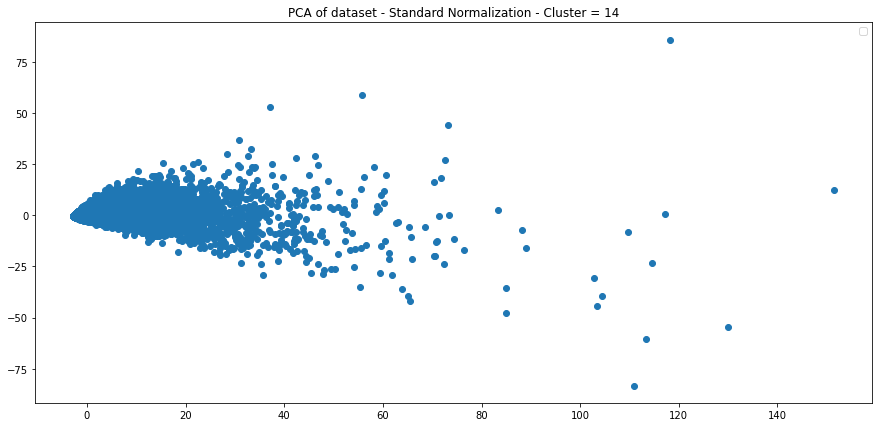

In [87]:
print(norm_clients_data)
PCA_Visualisation(norm_clients_data, method = 'Standard Normalization')